# Tratamiento de imágenes  2025 - Entregable 1
# Fecha de entrega: 13/04/2025

**Importante:** En todos los ejercicios se espera que se entregue comentarios sobre decisiones tomadas en la implementación así como un análisis de los resultados. Estos comentarios y análisis se pueden entregar en celdas de texto agregadas a los notebooks o en un informe aparte.

Para la entrega se sube un **zip** _(no .rar, ni otro formato)_ con:
* **El notebook del entregable modificado y con celdas ejecutadas**. El notebook debe tener las celdas ejecutadas con las salidas correspondientes. Debe tener todo lo necesario para poder ser ejecutado nuevamente
* **Todo el resto del contenido del zip del entregable**. Si, para mostrar resultados, usan en el notebook **imágenes propias**, deben incluirlas en la carpeta **imagenes**  del zip.
* El informe en pdf en caso de no incluir las discusiones dentro del notebook en celdas "Markdown", o si les resulta más sencillo realizar el análisis en un documento aparte.

**No se deben incluir en el zip** de la entrega las imágenes de prueba que están disponibles en la página web del curso. Se asumirá que esas imágenes están en un directorio y se hará referencia a dichas imágenes en forma relativa a ese directorio (ver la celda siguiente).
   

In [37]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
 # autoreload. Los cambios en modulos externos como 'funciones_practica_1.py' se recargan automaticamente
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import time


#Añado la ruta donde se ubica al PYTHONPATH
import sys
sys.path.append('/content/drive/MyDrive/timag/entregable_1')

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from skimage.io import imread, imsave

# Importar tests
from testing.tests import test_marching_squares, test_histograma
from testing.tests import test_add_gaussian_noise, test_add_saltpepper_noise


# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ----------------
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------



# Directorio con la base de imágenes de prueba (las que están en la web de Timag)
# Ej. si usan la imagen trapo.jpg en el notebook no tienen que subirla al eva
# La llaman en el notebook en forma relativa a donde tengan esas imagenes:
#
# filename = os.path.join(dir_base_imagenes, 'trapo.jpg')
# I = imread(filename)
dir_base_imagenes = '/content/drive/MyDrive/timag/entregable_1/imagenes'

## 1) Líneas de nivel

**1.1)** Escribir un programa que reciba una imagen y un conjunto de valores y muestre las líneas de nivel correspondientes a dichos valores. Para ello implementar el algoritmo marching squares. Ver https://en.wikipedia.org/wiki/Marching_squares

Utilizar **interpolación lineal** como se muestra en la referencia.


In [13]:
def interp(p1, p2, v1, v2, level):
    """
    Realiza la interpolación lineal entre DOS PUNTOS para determinar la
    intersección en el segmento (definido por p1 y p2) donde el valor cruza
    el umbral 'level'.

    Args:
        p1 (tuple): Coordenadas (x, y) del primer punto.
        p2 (tuple): Coordenadas (x, y) del segundo punto.
        v1 (float): Valor de la imagen en p1.
        v2 (float): Valor de la imagen en p2.
        level (float): Umbral para determinar la intersección.

    Returns:
        tuple: Coordenadas (x, y) del punto de intersección.
    """
    #Entonces, se quiere encontrar un punto intermedio,entre p1 y p2, dónde el valor sea exactamente un nivel(level)


    #Si ambos valores de los puntos evaluados son iguales(caso degenerado) no existe punto intermedio,
    #por lo que se puede devolver cualquiera de los dos puntos, en éste caso elegí p1
    if v1 == v2:
        x, y = p1
    else:
        #Si los valores de los puntos son diferentes, entonces procedo al cálculo fracción (t) que representa la posición del cruce en el segmento
        t = (level - v1) / (v2 - v1)
        #En dos dimensiones el punto exacto de la intersección(x,y) se cálcula utilizando la siguiente formnula:
        x = p1[0] + t * (p2[0] - p1[0])
        y = p1[1] + t * (p2[1] - p1[1])



    return (x, y)



def lineas_nivel(img, level):
    """
    Calcular líneas de nivel para una imagen dada. Las coordenadas de los
    contornos deben estar interpolados por los valores de los cuatro pixeles
    de la imagen en cada uno de los cuadrados.

    Args:
        img (array 2D): Imagen de entrada.
        level (int o float): Nivel.

    Returns:
        level_segments (list): lista que contiene los segmentos que forman las
        lineas del nivel 'level'. Lista vacía en caso de no tener lineas asociadas a dicho
        nivel. Los segmentos que forman las lineas del nivel se devuelven como una lista
        de pares de coordenadas, con el siguiente formato:

        [ [(xa_1,ya_1), (xb_1,yb_1)], ..., [(xa_N,ya_N),(xb_N,yb_N)] ],

        donde:
            xa_n la coordenada del eje x (columnas) del segmento n
            ya_n su correspondiente coordenada del eje y (filas) del segmento n.

          (x0,y0)------------------------(x0+1,y0)-->    x
             |                |
             |                |
             |                |
             |----------------|---------------
             |                |
             |                |
             |                |
         (x0,y0+1)------------|--------(x0+1,y0+1)
             |
             v

             y

    Ejemplo de uso:
    === Código ===
    >> grid = np.array([
    >>  [1, 1, 1, 1, 1],
    >>  [1, 2, 3, 2, 1],
    >>  [1, 3, 3, 3, 1],
    >>  [1, 2, 3, 2, 1],
    >>  [1, 1, 1, 1, 1]
    >>  ])
    >>
    >> level = 1.5
    >>
    >> lines = lineas_nivel(grid, level)
    >> lines
    === Salida ===
    >> [[(1, 0.5), (0.5, 1)], [(1, 0.5), (2, 0.25)], [(2, 0.25), (3, 0.5)], [(3, 0.5), (3.5, 1)], [(0.5, 1), (0.25, 2)], [(3.5, 1), (3.75, 2)], [(0.25, 2), (0.5, 3)], [(3.75, 2), (3.5, 3)], [(0.5, 3), (1, 3.5)], [(1, 3.5), (2, 3.75)], [(2, 3.75), (3, 3.5)], [(3, 3.5), (3.5, 3)]]
    """

    segmentos = []  #Almaceno los puntos de los contornos

    #imagen en punto flotante para evitar problemas de precisión en el cálculo de la interpolación
    img = img.astype(np.float64)

    filas, cols = img.shape


    #El recorrido del loop es hacer celda por celda de izquierda a derecha
    #Como son celdas de 2x2 con 4 puntos con la configuración de i+1 y j+1, para no excederme de los limites,
    #el bucle tiene que recorrer hasta filas-1 y columnas-1, para que i+1 y j+1 sigan siendo indices válidos
    for i in range(filas - 1):
        for j in range(cols - 1):

            #Separo la lógica en coordenadas de las celda y por otro lado los valores

            #Coordenadas(posición) de las cuatro esquinas de la celda
            esq_sup_izq = (j, i)         #Esquina superior izquierda
            esq_sup_der = (j + 1, i)       #"" superior derecha
            esq_inf_der = (j + 1, i + 1)   #"" inferior derecha
            esq_inf_izq = (j, i + 1)       #"" inferior izquierda

            #Valores(intensidad) de la imagen en cada esquina de la celda
            val_sup_izq = img[i, j]
            val_sup_der = img[i, j + 1]
            val_inf_der = img[i + 1, j + 1]
            val_inf_izq = img[i + 1, j]

            #Código binario para la celda
            #Se inicializa la variable config, que es la que almacena los valores en bits
            #El operado OR bit a bit (|=), asigna el bit correspondiente a la esquina, cuando el valor en esa esquina,es superior o igual, al nivel.
            #De este modo, cada esquina queda representada por un bit (0 o 1), y se combina todo en un solo número (config)
            #Esto da un rango de 2^4 valores distintos (de 0 a 15), permitiendo resumir la información de 4 esquinas con un único número.
            config = 0
            if val_sup_izq >= level:
                config |= 1  # Bit 0
            if val_sup_der >= level:
                config |= 2  # Bit 1
            if val_inf_der >= level:
                config |= 4  # Bit 2
            if val_inf_izq >= level:
                config |= 8  # Bit 3

            #Tabla de casos (edge table): relaciona cada config con el o los segmentos a generar.
            # Solo se consideran los casos en que se produce un cruce
            #ya que 0 y 15 que implican todo por debajo o todo por encima del nivel, sin cruce.

            edge_table = {
                1:  [(interp(esq_sup_izq, esq_inf_izq, val_sup_izq, val_inf_izq, level),
                      interp(esq_sup_izq, esq_sup_der, val_sup_izq, val_sup_der, level))],
                2:  [(interp(esq_sup_izq, esq_sup_der, val_sup_izq, val_sup_der, level),
                      interp(esq_sup_der, esq_inf_der, val_sup_der, val_inf_der, level))],
                3:  [(interp(esq_sup_izq, esq_inf_izq, val_sup_izq, val_inf_izq, level),
                      interp(esq_sup_der, esq_inf_der, val_sup_der, val_inf_der, level))],
                4:  [(interp(esq_inf_der, esq_sup_der, val_inf_der, val_sup_der, level),
                      interp(esq_inf_der, esq_inf_izq, val_inf_der, val_inf_izq, level))],
                5:  [  # Caso ambiguo con dos posibles segmentos
                      (interp(esq_sup_izq, esq_sup_der, val_sup_izq, val_sup_der, level),
                       interp(esq_sup_izq, esq_inf_izq, val_sup_izq, val_inf_izq, level)),
                      (interp(esq_sup_der, esq_inf_der, val_sup_der, val_inf_der, level),
                       interp(esq_inf_der, esq_inf_izq, val_inf_der, val_inf_izq, level))
                    ],
                6:  [(interp(esq_sup_izq, esq_sup_der, val_sup_izq, val_sup_der, level),
                      interp(esq_inf_der, esq_inf_izq, val_inf_der, val_inf_izq, level))],
                7:  [(interp(esq_sup_izq, esq_inf_izq, val_sup_izq, val_inf_izq, level),
                      interp(esq_inf_der, esq_inf_izq, val_inf_der, val_inf_izq, level))],
                8:  [(interp(esq_sup_izq, esq_inf_izq, val_sup_izq, val_inf_izq, level),
                      interp(esq_inf_der, esq_inf_izq, val_inf_der, val_inf_izq, level))],
                9:  [(interp(esq_sup_izq, esq_sup_der, val_sup_izq, val_sup_der, level),
                      interp(esq_inf_der, esq_inf_izq, val_inf_der, val_inf_izq, level))],
                10: [  #Ambiguo dos posibles segmentos
                      (interp(esq_sup_izq, esq_sup_der, val_sup_izq, val_sup_der, level),
                       interp(esq_sup_izq, esq_inf_izq, val_sup_izq, val_inf_izq, level)),
                      (interp(esq_sup_der, esq_inf_der, val_sup_der, val_inf_der, level),
                       interp(esq_inf_der, esq_inf_izq, val_inf_der, val_inf_izq, level))
                     ],
                11: [(interp(esq_inf_der, esq_sup_der, val_inf_der, val_sup_der, level),
                      interp(esq_inf_der, esq_inf_izq, val_inf_der, val_inf_izq, level))],
                12: [(interp(esq_sup_izq, esq_inf_izq, val_sup_izq, val_inf_izq, level),
                      interp(esq_sup_der, esq_inf_der, val_sup_der, val_inf_der, level))],
                13: [(interp(esq_sup_izq, esq_sup_der, val_sup_izq, val_sup_der, level),
                      interp(esq_sup_der, esq_inf_der, val_sup_der, val_inf_der, level))],
                14: [(interp(esq_sup_izq, esq_inf_izq, val_sup_izq, val_inf_izq, level),
                      interp(esq_sup_izq, esq_sup_der, val_sup_izq, val_sup_der, level))]
            }

            if config in edge_table:#Se accede al diccionario edge_table con la clave config y se invoca a la función de interpolación, con las variable predeterminadas
                for segmento in edge_table[config]:
                    #El par de coordenadas((x,y),(x,y)) o segmento, devuelto por la función interpolación
                    #se convierten a float y se agregan a la lista segmentos
                    punto_inicio = (float(segmento[0][0]), float(segmento[0][1]))
                    punto_final  = (float(segmento[1][0]), float(segmento[1][1]))
                    segmentos.append([punto_inicio, punto_final])

    return segmentos

**1.2)** Probar implementación y visualizar resultados en casos sencillos.

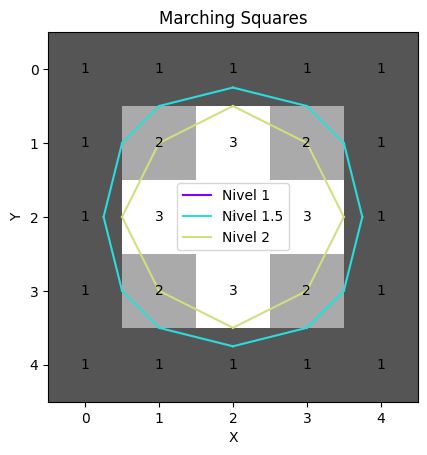

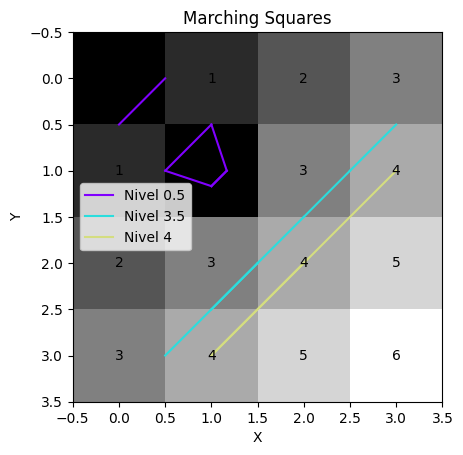

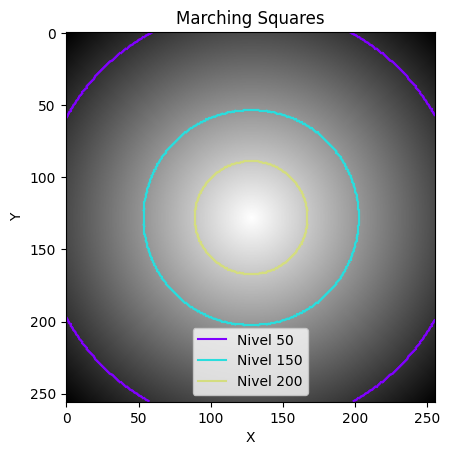

In [16]:
#----------------------------------------
# IMAGENES DE EJEMPLO m1, m2 y m3

m1 = np.array([
    [1, 1, 1, 1, 1],
    [1, 2, 3, 2, 1],
    [1, 3, 3, 3, 1],
    [1, 2, 3, 2, 1],
    [1, 1, 1, 1, 1]
])
levels1 = [1, 1.5, 2]

m2 = np.array([
     [0, 1, 2, 3],
     [1, 0, 3, 4],
     [2, 3, 4, 5],
     [3, 4, 5, 6]
])
levels2 = [0.5, 3.5, 4]


#m3 = imread('imagenes/cono.png')
filename = os.path.join(dir_base_imagenes, 'cono.png')
m3 = imread(filename)

levels3 = [50, 150, 200]
#----------------------------------------


#----------------------------------------
# PARA CADA IMAGEN Y SUS CORRESPONDIENTES NIVELES
for Z, thresholds in zip([m1,m2,m3],[levels1, levels2, levels3]):


    #----------------------------------------
    # MOSTRAR LA IMAGEN

    # Create a 2D grid with some data
    x = np.arange(Z.shape[1])
    y = np.arange(Z.shape[0])
    X, Y = np.meshgrid(x, y)

    # Crear imagen
    plt.figure()
    plt.imshow(Z, vmin=0, vmax=np.max(Z),cmap='gray')

    # Valor de pixeles en texto (para las imágenes pequeñas m1 y m2)
    if Z is m1 or Z is m2:
        for y in range(Z.shape[0]):
            for x in range(Z.shape[1]):
                plt.text(x , y, '%.0f' % Z[y, x],
                        horizontalalignment='center',
                        verticalalignment='center'
                        )


    #----------------------------------------
    # DIBUJAR SOBRE LA IMAGEN LAS LINEAS DE NIVEL

    # Elegir colores del colormap "rainbow"
    colors = iter(cm.rainbow(np.linspace(0, 1, len(thresholds)+1)))

    # Trazar lineas de nivel
    for level in thresholds:
        lines = lineas_nivel(Z, level)
        color = next(colors)
        x_points, y_points = 0,0
        for line in lines:
            x_points, y_points = zip(*line)
            plt.plot(x_points, y_points, color=color)
        plt.plot(x_points, y_points, color=color, label=f'Nivel {level}')

    plt.title("Marching Squares")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

Correr siguiente celda para testear la implementación.

In [14]:
# Testear función implementada
assert test_marching_squares(lineas_nivel), 'Revisar los errores'

APRUEBA caso 0 de marching squares.
APRUEBA caso 1 de marching squares.
APRUEBA caso 2 de marching squares.
APRUEBA caso 3 de marching squares.
APRUEBA caso 4 de marching squares.
APRUEBA caso 5 de marching squares.
APRUEBA caso 6 de marching squares.
APRUEBA caso 7 de marching squares.
APRUEBA caso 8 de marching squares.

FALLA el caso 9, con matriz:
[[60 20]
 [30 70]] 
y nivel:
50.
Implementación:	[[(0.25, 0.0), (0.0, 0.3333333333333333)], [(1.0, 0.6), (0.5, 1.0)]]
Esperado:	[[(0, 0.3333333333333333), (0.5, 1)], [(0.25, 0), (1, 0.6)]]


FALLA el caso 9, con matriz:
[[60 20]
 [30 70]] 
y nivel:
50.
Implementación:	[[(0.25, 0.0), (0.0, 0.3333333333333333)], [(1.0, 0.6), (0.5, 1.0)]]
Esperado:	[[(0, 0.3333333333333333), (0.5, 1)], [(0.25, 0), (1, 0.6)]]


FALLA el caso 10, con matriz:
[[20 70]
 [30 90]] 
y nivel:
50.
Implementación:	[[(0.6, 0.0), (0.33333333333333337, 1.0)]]
Esperado:	[[(0.6, 0), (0.3333333333333333, 1)]]


FALLA el caso 11, con matriz:
[[60 70]
 [30 90]] 
y nivel:
50.


AssertionError: Revisar los errores

**1.3)** Aplicar lineas de nivel a una **imagen natural** (foto de una persona, animal, paisaje, etc) y una **imagen artificial**. Comparar con la función [contour de matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html).  
* Comparar salidas
* Comparar tiempo de ejecución



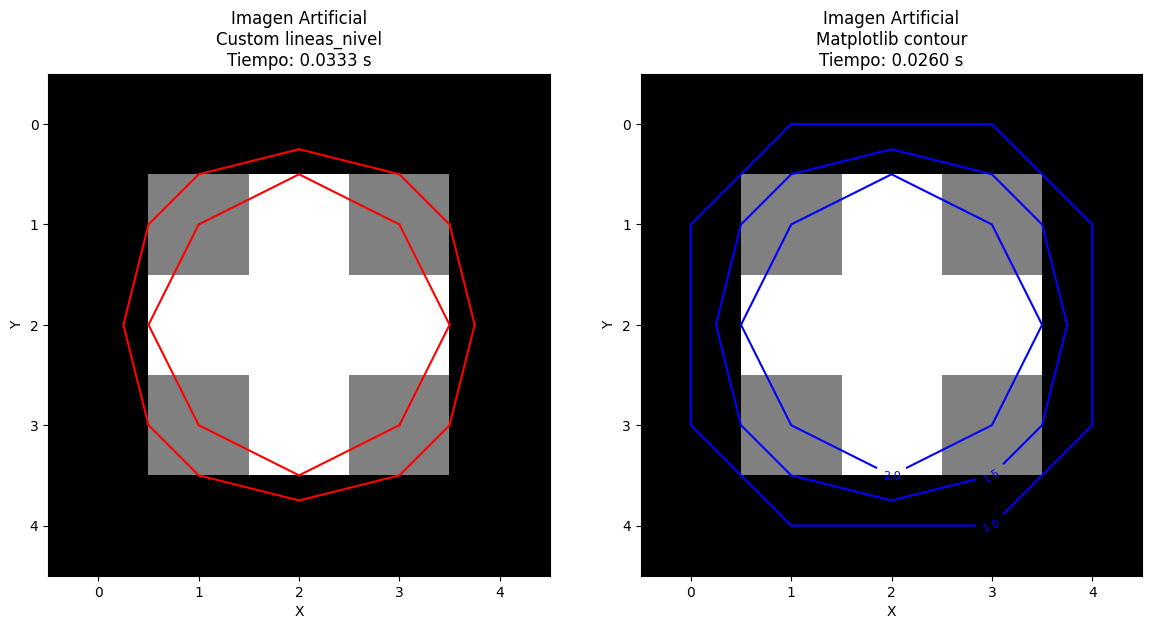

Imagen Artificial (m1):
Tiempo Custom lineas_nivel: 0.0333 s
Tiempo Matplotlib contour: 0.0260 s


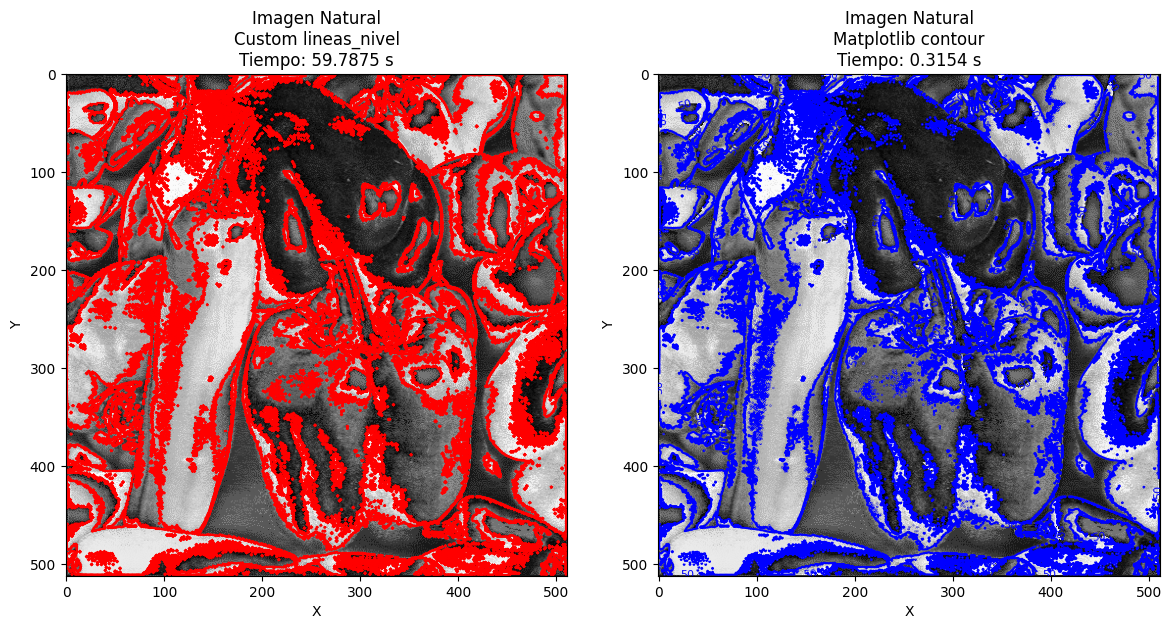

Imagen Natural:
Tiempo Custom lineas_nivel: 59.7875 s
Tiempo Matplotlib contour: 0.3154 s


In [19]:
import time

# Definir la imagen artificial (m1) y sus niveles
m1 = np.array([
    [1, 1, 1, 1, 1],
    [1, 2, 3, 2, 1],
    [1, 3, 3, 3, 1],
    [1, 2, 3, 2, 1],
    [1, 1, 1, 1, 1]
])
levels_m1 = [1, 1.5, 2]



filename = os.path.join(dir_base_imagenes, 'peppers.png')
img_natural = imread(filename)


#Verificar si la imagen es a color (tres dimensiones) y convertirla a escala de grises
if img_natural.shape != 1:
    #Separar los tres canales
    R = img_natural[:, :, 0]
    G = img_natural[:, :, 1]
    B = img_natural[:, :, 2]

    #Para tener un único valor de intensidad de ese pixel hago el promedio de los tres canales
    img_natural = (R + G + B) / 3.0

levels_natural = [50, 150, 200]

# ----------------------------------------------------------------------
# Comparación para la Imagen Artificial (m1)
# ----------------------------------------------------------------------
m1_float = m1.astype(np.float64)

#----------------------------------------------
# Aplico la función definida de lineas de nivel
#----------------------------------------------
start_custom = time.time()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(m1_float, cmap='gray')
for level in levels_m1:
    segmentos = lineas_nivel(m1_float, level)
    for seg in segmentos:
        x_points, y_points = zip(*seg)
        plt.plot(x_points, y_points, color='red')
time_custom = time.time() - start_custom
plt.title(f"Imagen Artificial\nCustom lineas_nivel\nTiempo: {time_custom:.4f} s")
plt.xlabel("X")
plt.ylabel("Y")

#----------------------------------
# Ploteo la imagen artificial con plt.contour
#------------------------------------
start_contour = time.time()
plt.subplot(1, 2, 2)
plt.imshow(m1_float, cmap='gray')
CS = plt.contour(m1_float, levels=levels_m1, colors='blue')
plt.clabel(CS, inline=True, fontsize=8)
time_contour = time.time() - start_contour
plt.title(f"Imagen Artificial\nMatplotlib contour\nTiempo: {time_contour:.4f} s")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

print("Imagen Artificial (m1):")
print(f"Tiempo Custom lineas_nivel: {time_custom:.4f} s")
print(f"Tiempo Matplotlib contour: {time_contour:.4f} s")

# ----------------------------------------------------------------------
# Comparación para la Imagen Natural
# ----------------------------------------------------------------------

#Imagen natural a float64 para operaciones aritméticas
img_natural_float = img_natural.astype(np.float64)

#----------------------------------------------
# Aplico la función definida de lineas de nivel
#----------------------------------------------
start_custom = time.time()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_natural_float, cmap='gray')
for level in levels_natural:
    segmentos = lineas_nivel(img_natural_float, level)
    for seg in segmentos:
        x_points, y_points = zip(*seg)
        plt.plot(x_points, y_points, color='red')
time_custom = time.time() - start_custom
plt.title(f"Imagen Natural\nCustom lineas_nivel\nTiempo: {time_custom:.4f} s")
plt.xlabel("X")
plt.ylabel("Y")

#----------------------------------------
# Ploteo la imagen natural conplt.contour
#---------------------------------------
start_contour = time.time()
plt.subplot(1, 2, 2)
plt.imshow(img_natural_float, cmap='gray')
CS = plt.contour(img_natural_float, levels=levels_natural, colors='blue')
plt.clabel(CS, inline=True, fontsize=8)
time_contour = time.time() - start_contour
plt.title(f"Imagen Natural\nMatplotlib contour\nTiempo: {time_contour:.4f} s")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

print("Imagen Natural:")
print(f"Tiempo Custom lineas_nivel: {time_custom:.4f} s")
print(f"Tiempo Matplotlib contour: {time_contour:.4f} s")

## 2) Histograma

**a)** Implementar funciones que calculen el histograma e histograma acumulado de una array.  
La implementación del histograma deberá dar una salida igual a la función **np.histogram**  

In [20]:
def histograma(arr, bins, rango=None):
    """
    Calcula el histograma de un arreglo.
    Devuelve el histograma y los bins correspondientes.

    Args:
        arr (ndarray): El arreglo de entrada (puede ser una imagen).
        bins (int): El número de bins a utilizar.
        rango (float, float), opcional. Rango mínimo y máximo para los bins. Si no
                                        se pasa, se toma el mínimo y máximo del arreglo

    Returns:
        counts (1D-array de largo bins): Cantidad de muestras en cada bin
        bin_edges (1D-array de largo bins +1): Los bordes de los bins utilizados para calcular el histograma.
    """

    """
  El histograma se basa en la división del dominio de los datos(bins)en intervalos, de forma uniforme, entre el minimo y el máximo del arreglo
  Si no se indica un rango, usamos el valor mínimo y máximo del arreglo como extremos.
  """
    if rango is None:
      #Obs: Si hay "outliers", o sea valores muy altos o bajos, pueden terminar "estirando"el histograma
      #Esto podría generar que todos los demás valores caigan juntos en poco bins
        min_val = np.min(arr)
        max_val = np.max(arr)
    else:
        min_val, max_val = rango

    """ Para dividir el rango en bins intervalos (cada intervalo se define por dos bordes consecutivos).
    La convención es que cada intervalo es cerrado por la izquierda y abierto por la derecha, salvo el último que incluye el borde derecho."""
    #Se usa np.linspace(a, b, n) para crear los bordes.
    #n representa los puntos espaciados uniformemente entre el rango a y b (ambos incluidos)
    #Si quieres dividir un rango en intervalos(bins), necesitas n + 1 bordes(bins+1)
    bin_edges = np.linspace(min_val, max_val, bins + 1)


    #Se crea un array(lista) de ceros que almacenará cuántos valores caen en cada bin
    counts = np.zeros(bins, dtype=int)

    """
    El histograma representa la distribución de los valores de gris(intensidad) en toda la imagen, sin importar dónde están esos valores espacialmente.
    O sea, no nos importa la posición de cada "pixel", sino, qué valor tiene y cuantas veces se repite.
    Para ello se usa el método flatten() que conviente una imagen dos dimensiones(filasxcolumnas) en un vector de una dimensión(lista)
    """
    for valor in arr.flatten():
        # Ignorar valores fuera de rango
        if valor < min_val or valor > max_val:
            continue

        if valor == max_val:
            #Se contempla cuando el valor se ubica en el último bin, emulando el cerramiento por la derecha del último bin
            bin_index = bins - 1
        else:

            bin_index = int((valor - min_val) / (max_val - min_val) * bins)
            #Explicación de la división: (valor - min_val) / (max_val - min_val)
            #1) (valor - min_val): mide la distancia del valor respecto al inicio del rango.
            #2) (max_val - min_val): Es el rango en el que está contenido
            #3) La división (valor - min_val) / (max_val - min_val) indica la proporción(%), en relación al inicio del rango, en dónde se ubica dicho valor.

            #4) Al multiplicar dicha proporción, por el numero total de bins, obtenemos en cual de todos los bin se cae el "valor"
            #5) La función int() trunca los decimales, generando un redondeo de los números hacía abajo, transformando el resultado de las cuentas, a entero.
            # Esto es importante ya que, permite cumplir con la condición definida para los bins, de ser cerrados por la izquierda y abiertos por la derecha
            # Inclusive si el el valor es muy proximo al borde derecho, sigue cayendo en un bin válido(bin_index)

        #Counts: array con la cantidad de elementos en cada bin
        counts[bin_index] += 1

    return counts, bin_edges


def histograma_acumulado(arr, bins, rango=None):
    """
    Calcula el histograma acumulado de un arreglo.
    Devuelve el histograma acumulado y los bins correspondientes.

    Args:
        arr (ndarray): El arreglo de entrada (puede ser una imagen).
        bins (int): El número de bins a utilizar.
        rango (float, float), opcional. Rango mínimo y máximo para los bins. Si no
                                        se pasa, se toma el mínimo y máximo del arreglo

    Returns:
        counts (1D-array de largo bins): Cantidad de muestras acumuladas en cada bin
        bin_edges (1D-array de largo bins +1): Los bordes de los bins utilizados.
    """

    counts, bin_edges = histograma(arr,bins,rango=None)# Extraigo l

    #Genero un array, lleno de ceros, del mismo tamaño que counts
    #Este array servirá para almacenar, en cada posición, la suma acumulada de los conteos desde el primer bin hasta el actual.
    acumulado = np.zeros_like(counts)

    # Inicalizo el contador
    suma=0

    #Como el histograma acumulado se define de modo que, cada posición contiene la suma de todos los conteos hasta ese punto.
    for i in range(len(counts)):# recorre cada posición del array counts
      suma+=counts[i]#1)suma el valor de arreglo counts en la posición i a la variable suma
      acumulado[i]=suma#2)Asigna ese valor suma, al array acumulado en la posición i

    #Me queda más intuitivo hacerlo así
    counts = acumulado

    return counts, bin_edges

Comparar resultados con [`histogram`](https://numpy.org/doc/2.1/reference/generated/numpy.histogram.html) de numpy con el siguiente test:

In [21]:
# Testear función histograma implementada
assert test_histograma(histograma), 'Revisar los errores'

APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 10 y RANGOS: None.
APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 10 y RANGOS: 0_100.
APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 10 y RANGOS: 50_256.
APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 10 y RANGOS: -255_25.
APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 100 y RANGOS: None.
Hay diferencia entre los histogramas usando nbins=100, rango=(0, 100) y arreglo arr_key='np.arange_0-100'.
Ver la imagen /content/testing/hist_errors/np.arange_0-100_BINS_100_RANGO_0_100.png

APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 100 y RANGOS: 50_256.
APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 100 y RANGOS: -255_25.
APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 256 y RANGOS: None.
APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 256 y RANGOS: 0_100.
APRUEBA histograma usando ARRAY: np.arange_0-100, NBINS: 256 y RANGOS: 50_256.
APRUEBA histograma usando AR

AssertionError: Revisar los errores

**b)** Analizar cualitativamente los histogramas (común y acumulado) de las imágenes oclusion.bmp y retina.bmp para los casos:

* `nbins=256`, `rango=None`
* `nbins=10`, `rango=None`
* `nbins=256`, `rango=(70, 200)`

Para el despliegue de los histogramas se sugiere utilizar la función **[plt.stairs](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stairs.html)**


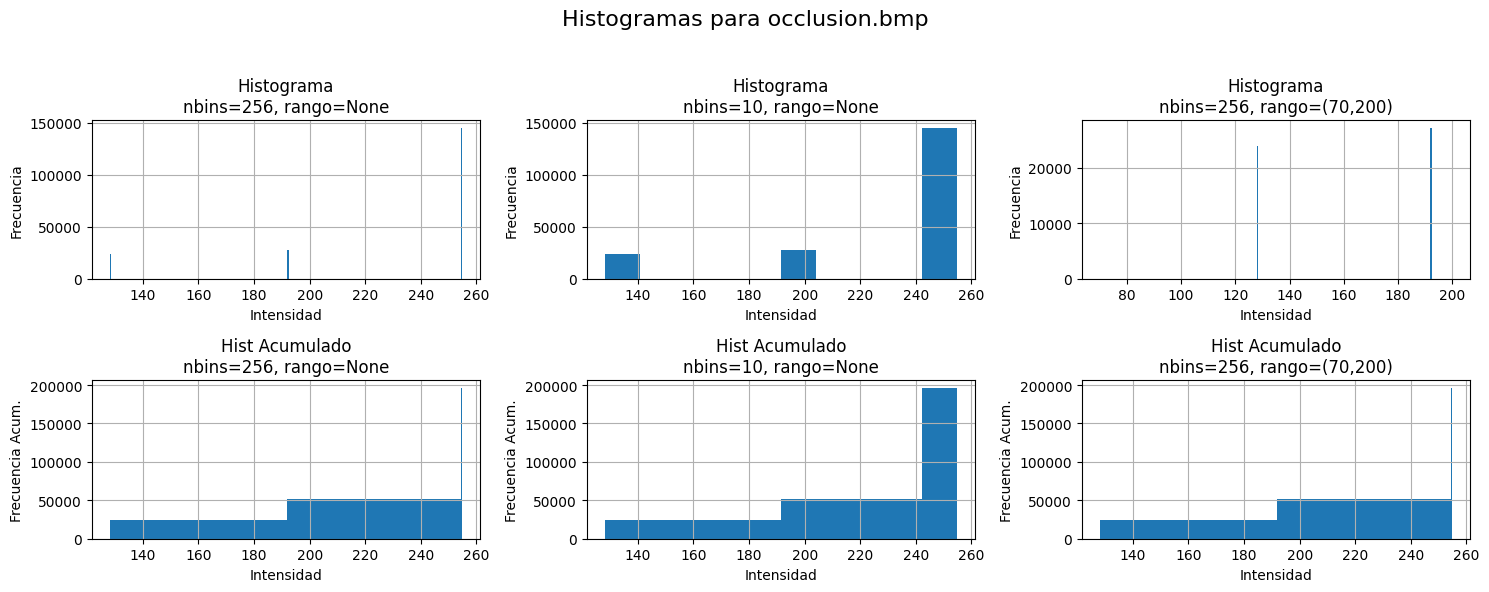

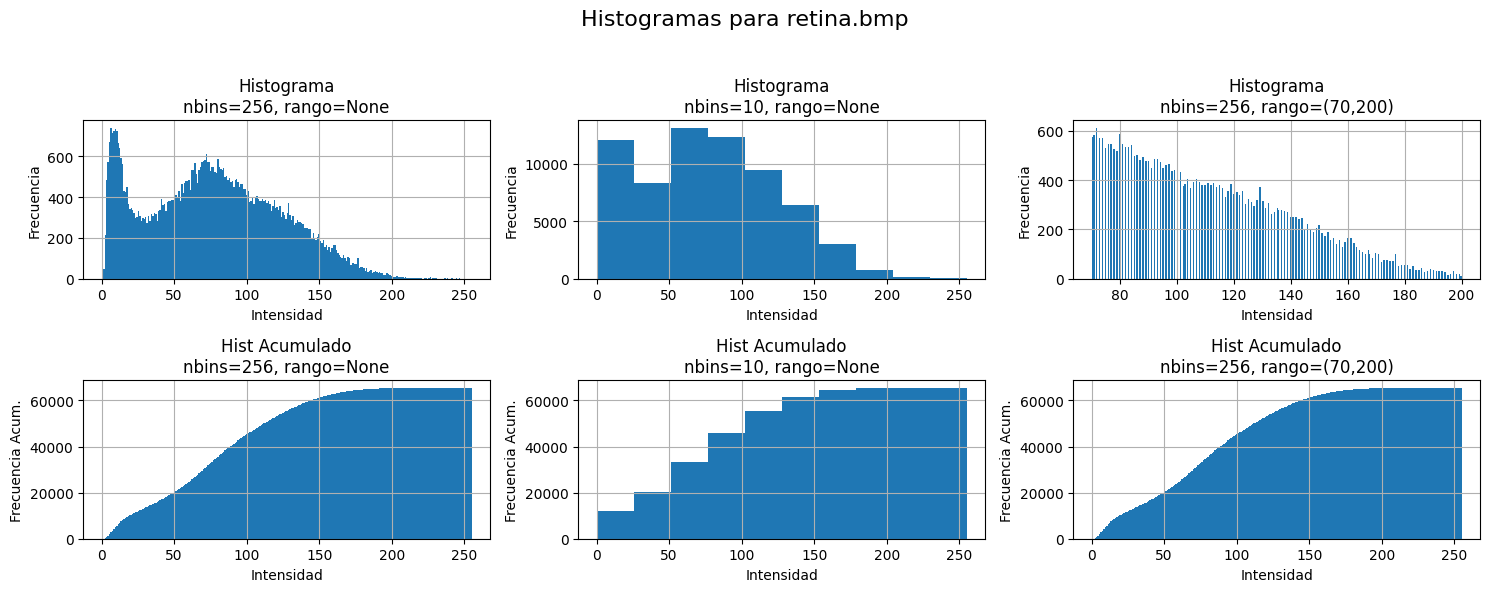

In [22]:

#Imagenes a usar
filename_occlusion = os.path.join(dir_base_imagenes, 'oclusion.bmp')
filename_retina= os.path.join(dir_base_imagenes, 'retina.bmp')

img_occlusion = imread(filename_occlusion)
img_retina    = imread(filename_retina)


casos = [{"nbins": 256, "rango": None,       "titulo": "nbins=256, rango=None"},
{"nbins": 10,  "rango": None,       "titulo": "nbins=10, rango=None"},
    {"nbins": 256, "rango": (70, 200),    "titulo": "nbins=256, rango=(70,200)"}]

#Etiqueto las imagenes
imagenes = [(img_occlusion, "occlusion.bmp"), (img_retina, "retina.bmp")]

#Visualización de cada imagen
for img, label in imagenes:
    num_casos = len(casos)
    plt.figure(figsize=(15, 6))
    plt.suptitle(f"Histogramas para {label}", fontsize=16)

    #Para cada caso se generan dos subplots: uno para histograma común y otro para el acumulado.
    #Para el despliegue utilizo el metodo sugerido pl.stairs
    for idx, caso in enumerate(casos):
        nbins  = caso["nbins"]
        rango  = caso["rango"]
        titulo = caso["titulo"]

        counts, bin_edges = histograma(img, nbins, rango)
        counts_acum, bin_edges_acum = histograma_acumulado(img, nbins, rango)

        #Histograma
        plt.subplot(2, num_casos, idx + 1)
        plt.stairs(counts, bin_edges, fill=True)
        plt.title(f"Histograma\n{titulo}")
        plt.xlabel("Intensidad")
        plt.ylabel("Frecuencia")
        plt.grid(True)

        #Histograma acumulado
        plt.subplot(2, num_casos, num_casos + idx + 1)
        plt.stairs(counts_acum, bin_edges_acum, fill=True)
        plt.title(f"Hist Acumulado\n{titulo}")
        plt.xlabel("Intensidad")
        plt.ylabel("Frecuencia Acum.")
        plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**c)** Describir para qué se puede utilizar la _ecualización del histograma_ para una imagen y qué se espera del nuevo histograma de salida.

**_Respuesta:_** ...
La ecualización del histograma se usa para mejorar el contraste de una imagen, permitiendo realzar detalles en áreas que estaban poco diferenciadas(muy oscuras/brillantes) se vuelven más visibles. Eso se logra redistribuyendo los niveles de intensidad de modo que se aproveche de forma óptima el rango dinámico disponible.

Tras la ecualización el histograma se debería distribuir forma más uniforme a lo largo de todo el rango de intensidades. Se puede esperar que se mantengan picos de amplitud en ciertos bins, pero más extendidos y con una mayor separación entre bins con y sin frecuencia.

### Conceptos relevantes para entender la ecualización de histograma:

####    La Función de Densidad de Probabilidad(PDF):

    La PDF representa la probabilidad de que un píxel tenga un determinado valor de intensidad.

    Para ello se divide cada frecuencia, es decir la cantidad de pixeles que caen en cada bin,por el número total de pixeles de la imagen, para así obtener la probabilidad de ocurrencia de cada nivel.

    Implicación: Permite pasar de frecuencias absolutas(número de veces que aparece un valor en un conjunto de datos),
    a una medida relativa (proporción de ese valor en relación con el total) que suma 1 en total.

    Ejemplo: counts = [500, 1500, 2000, …]
    Para el primer bin: pdf[0] = 500 / 10000 = 0.05
    Esto significa que el 5% de los pixeles tienen el valor de intesidad que corresponde a ese primer bin.

#### Función de Distribución Acumulativa(CDF)

    La CDF indica la probabilidad acumulada hasta cada nivel de intensidad.
    La misma se utiliza, para redistribuir las intensidades de la imagen,
    de modo que se extienda de forma uniforme a lo largo del rango dinámico, mejorando el contraste.

    Esto genera una distribución de probabilidades que suma 1, obtenida a través de la suma de forma acumulativa de los valores de la PDF.
    Por ello es una función monótona creciente, que va de 0 a 1, donde cada valor indica el porcentaje(%) de píxeles con intensidad menor o igual a un cierto nivel

    Calcula la suma acumulativa de la PDF.
    Por ejemplo si pdf = [p0, p1, p2, ...], entonces
    cdf[0] = p0, cdf[1] = p0 + p1, etc.

    Implicación:
    Al transformar la imagen usando la CDF normalizada, se "estiran" las intensidades concentradas en ciertos rangos y se comprimen aquellas con menos píxeles.
    Esto permite que la imagen use todo su rango dinámico, resultando en un contraste mejorado.

#### Look-Up Table
    
    Se utiliza para remapear los valores de intensidad originales de una imagen a nuevos valores que extiendan de forma uniforme el rango dinámico mejorando así el contraste.

    LUT[i]=round((CDF[i] - CDFmin)/(1-CDFmin)x(L-1)

    CDF[i]: es la función de distribución acumulativa para el nivel.
    CDFmin:es el 1er valor no nulo de la CDF
    L:número total de niveles de intensidad(256, en imagenes de 8 bits)


##### Conceptos complementarios
    Rango Dinámico:
    Es el intervalo de intensidades que una imagen puede representar (por ejemplo, de 0 a 255 en imágenes de 8 bits).

    Contraste Mejorado:
    Se refiere a la capacidad de la imagen ecualizada de utilizar de forma más completa el rango dinámico,
    de modo que las diferencias entre las intensidades sean más pronunciadas y se aprecie mayor detalle.
    
    


In [23]:
def ecualizar_histograma(I):
    """
    Aplicar cambio de contraste a la imagen mediante la
    ecualización de su histograma.

    Args:
        I (ndarray): Imagen de entrada

    Returns:
        I_ecualizada (ndarray): imagen ecualizada
    """

    # Se define una imagen con esacala de grises de 8 bits, así simplificamos los calculos y lo comparamos con las demás funciones de ecualización
    bins = 256

    #Calcular el histograma de la imagen
    #Recordatorio: la función histograma definida antetiormente divide el rango [0, 255] en 256 intervalos
    #(con 257 bordes) y cuenta cuántos píxeles caen en cada intervalo
    #nos da información acerca de la distribución de frecuencias de los valores de intensidad(niveles de gris) sin importar la posición espacial de los píxeles
    counts, bin_edges = histograma(I, bins, rango=(0, 255))


    total_pixels = I.size
    #La Función de Densidad de Probabilidad(PDF)
    pdf = counts / total_pixels

    #Cálculo de Función de Distribución Acumulativa(CDF)
    cdf = np.cumsum(pdf)

    # Normalizar la CDF para que tome valores entre 0 y 255.
    # Se resta el mínimo valor de la CDF (excluyendo ceros) y se escala.
    # Esto se hace para que el contraste se distribuya a lo largo de toda la gama

    #Identificar el primer valor no nulo de la CDF (cdf_min), ya que las imagenes la CDF puede comenzar con ceros

    cdf_nonzero = cdf[cdf > 0]
    if cdf_nonzero.size > 0:
        cdf_min = cdf_nonzero[0]
    else:
        cdf_min = 0

    #Formula para el cálculo de Look-Up Table
    #LUT[i] = round((cdf[i] - cdf_min) / (1 - cdf_min) * (L - 1))
    #donde L es el número total de niveles (256 para 8 bits)

    lut = ((cdf - cdf_min) / (1 - cdf_min) * (bins - 1)).round().astype('uint8')
    #Desglose de los terminos:
    #1) (cdf - cdf_min): Se resta el valor mínimo no nulo de la CDF (cdf_min) a cada elemento de la CDF.Esto "desplaza" la CDF para que comience en cero
    #2) (1- cdf_min): La diferencia entre 1 ( valor máximo teórico de la CDF) y cdf_min, para obtener el "rango efectivo" de CDF
    # Como consecuencia, se normaliza la CDF para que varíe en la escala de 0 a 1, crucial para mapear las intensidades de forma uniforme
    #3) (bins - 1): Dada una imagen de 8 bits, los bins suelen ser 256, entonces bins - 1 es 255
    # Entonces Multiplicar la CDF normalizada por 255, escala los valores a la gama de intensidades de la imagen(0 a 255)
    #4).round().astype('uint8'):Se redondean los valores resultantes al entero más cercano y se convierten a tipo uint8(niveles de intensidad de una imagen de 8 bits)

    #Aplicación de la tabla de consulta (look-up table) para transformar la imagen.
    #Cada píxel de la imagen original se reemplaza(mapea) por su valor correspondiente en la LUT.
    I_ecualizada = lut[I.astype('uint8')]

    return I_ecualizada

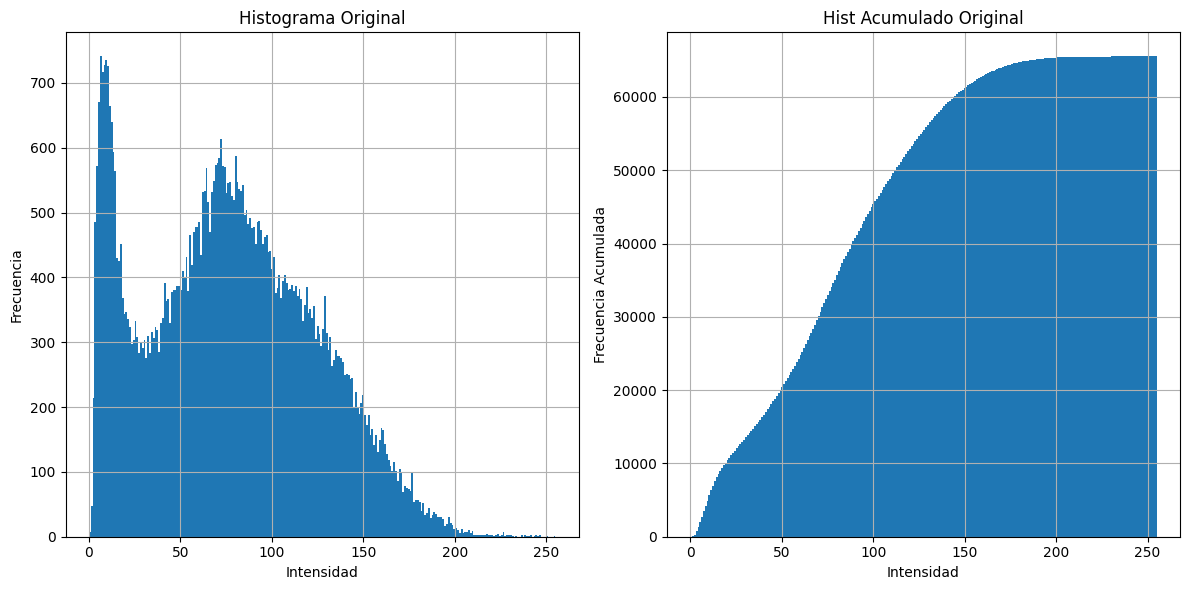

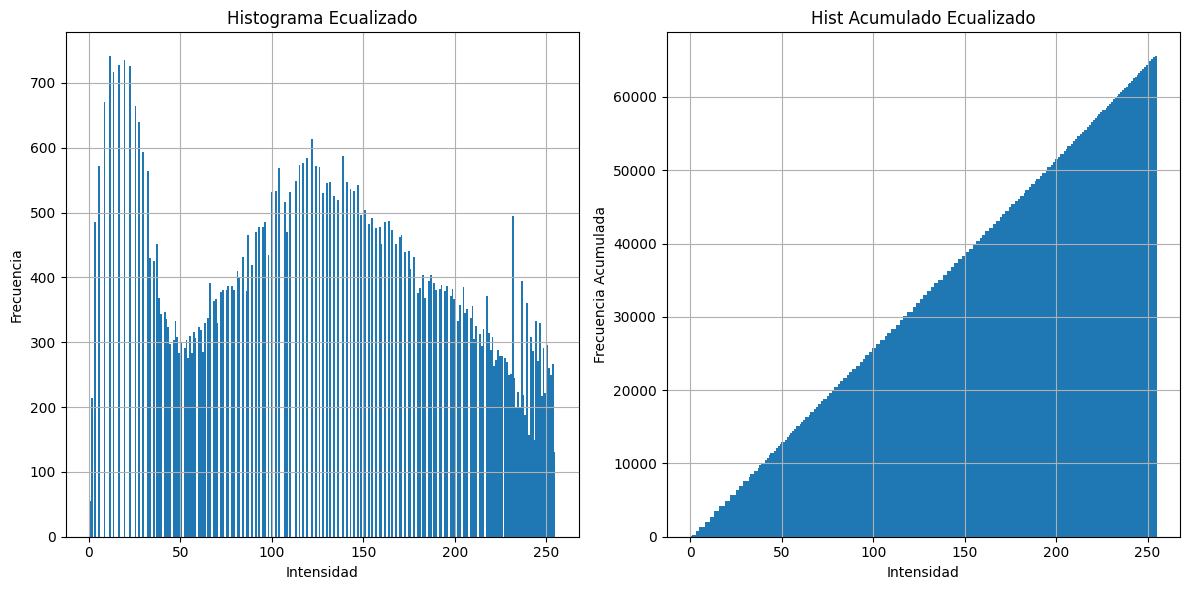

In [24]:
#---------------------------------------------------------------
#Ecualización de la  retina
#Se muestran los histogramas antes y después de la ecualización
#--------------------------------------------------------------

filename_retina = os.path.join(dir_base_imagenes, 'retina.bmp')
img_retina = imread(filename_retina)

#Histograma y acumulado de la imagen original
counts_orig, bin_edges_orig = histograma(img_retina, 256, None)
counts_acum_orig, _ = histograma_acumulado(img_retina, 256, None)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.stairs(counts_orig, bin_edges_orig, fill=True)
plt.title("Histograma Original")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.stairs(counts_acum_orig, bin_edges_orig, fill=True)
plt.title("Hist Acumulado Original")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia Acumulada")
plt.grid(True)

plt.tight_layout()
plt.show()

#Aplicar ecualización del histograma a la imagen retina.bmp
img_retina_eq = ecualizar_histograma(img_retina)

#Histograma y acumulado de la imagen ecualizada
counts_eq, bin_edges_eq = histograma(img_retina_eq, 256, None)
counts_acum_eq, _ = histograma_acumulado(img_retina_eq, 256, None)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.stairs(counts_eq, bin_edges_eq, fill=True)
plt.title("Histograma Ecualizado")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.stairs(counts_acum_eq, bin_edges_eq, fill=True)
plt.title("Hist Acumulado Ecualizado")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia Acumulada")
plt.grid(True)

plt.tight_layout()
plt.show()

**_¿Cómo se ven el histograma e histograma acumulado de la imagen ecualizada?_**

_Respuesta:_

El histograma ecualizado reparte los valores de intensidad a lo largo de todo el rango (0–255). A diferencia del histograma original, que mostraba concentraciones de píxeles en ciertos rangos, como cercanos al cero y entre los bins 50 y 100. En ese sentido, el histograma ecualizado aparece más “extendido”, manteniendo los picos en amplitud de ciertos bins, como sucedía en el histograma original pero más distribuidos.
También se ve una clara separación de los bins en el histograma ecualizado, debido a que al mapear con la LUT, saltos más evidentes en la discretización de los valores.

El histograma acumulado se ve como una linea diagonal(lineal) que crece desde la intensidad más baja a la más alta. Esto quiere decir que que para cada intensidad se están acumulando una cantidad similar de pixeles. Lo anterior, es precisamente el objetivo de la ecualización que la función de distribución acumulativa(CDF) se acerque lo más posiblea una recta 0-255(0 a 1) en la escala de intensidades.

...

**d)** Matching de histogramas

**Implementar** el ajuste de histograma para una imagen al de otra imagen. Mostrar imágenes, histograma e histograma acumulado de cada una.

Comparar visualmente mostrando los histogramas acumulados de la imagen referencia y de la imagen con el matching, superponiendolos en una misma gráfica .

Imágenes sugeridas: parot1.png, parot2.png, strike1.png, strike2.png

In [25]:
def matching_histogramas(I, I_ref):
    """
    Aplicar cambio de contraste a una imagen mediante el
    matching de su histograma con el de una imagen de
    referencia.

    Args:
        I (ndarray): Imagen a modificar su histograma
        I_ref (ndarray): Imagen con  histograma de referencia

    Returns:
        I_matched (ndarray): imagen de entrada con histograma modificado
    """

    bins = 256  # Para imágenes de 8 bits se usan 256 niveles (0-255).

    #Calcular el histograma de la imagen I usando la función histograma definida manualmente.
    counts_I, _ = histograma(I, bins, rango=(0, 255))
    # Calcular la CDF para I (suma acumulativa normalizada)
    cdf_I = counts_I.cumsum().astype(np.float64)
    cdf_I /= cdf_I[-1]  # Normalizamos para que la CDF varíe entre 0 y 1

    #Calcular el histograma de la imagen de referencia I_ref usando la misma función.
    counts_ref, _ = histograma(I_ref, bins, rango=(0, 255))
    #Calcular la CDF para I_ref y normalizarla
    cdf_ref = counts_ref.cumsum().astype(np.float64)
    cdf_ref /= cdf_ref[-1]

    #Crear la Look-Up Table (LUT) para mapear cada nivel de I al nivel de I_ref que tenga la CDF más cercana.
    LUT = np.zeros(bins, dtype=np.uint8)
    for i in range(bins):
        # Para cada nivel de gris i en I, se busca el índice j en I_ref tal que la diferencia
        # |cdf_I[i] - cdf_ref[j]| sea mínima.
        diff = np.abs(cdf_I[i] - cdf_ref)
        LUT[i] = np.argmin(diff)

    #Aplicar la LUT a la imagen I para obtener la imagen con histogramas ajustados.
    I_matched = LUT[I.astype(np.uint8)]
    return I_matched

In [26]:


# Se cargan imágenes de referencia y a ajustar
filename_parot1 = os.path.join(dir_base_imagenes, 'parot1.png')
filename_parot2 = os.path.join(dir_base_imagenes, 'parot2.png')
filename_strike1 = os.path.join(dir_base_imagenes, 'strike1.png')
filename_strike2 = os.path.join(dir_base_imagenes, 'strike2.png')
parot1 = imread(filename_parot1)
parot2 =imread(filename_parot2)
strike1 = imread(filename_strike1)
strike2 = imread(filename_strike2)

# Aplicar el matching de histogramas
# Se ajusta parot2 para que tenga el histograma de parot1,
# y se ajusta strike2 para que tenga el histograma de strike1.
parot2_matched = matching_histogramas(parot2, parot1)
strike2_matched = matching_histogramas(strike2, strike1)

#-------------------------------------------------------------------------------------
#Defino función para calcular y mostrar imágenes, histogramas y histogramas acumulados
#-----------------------------------------------------------------------------------
def plot_matching_results(original, reference, matched, title_prefix):
    # Calcular histogramas y histogramas acumulados para cada imagen
    counts_orig, bin_edges = histograma(original, 256, (0, 255))
    counts_acum_orig, _ = histograma_acumulado(original, 256, (0, 255))

    counts_ref, _ = histograma(reference, 256, (0, 255))
    counts_acum_ref, _ = histograma_acumulado(reference, 256, (0, 255))

    counts_matched, _ = histograma(matched, 256, (0, 255))
    counts_acum_matched, _ = histograma_acumulado(matched, 256, (0, 255))

    #Se crean figuras para visualizar resultados
    plt.figure(figsize=(18, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"{title_prefix}: Imagen original (a ajustar)")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(reference, cmap='gray')
    plt.title(f"{title_prefix}: Imagen de referencia")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(matched, cmap='gray')
    plt.title(f"{title_prefix}: Imagen luego del matching")
    plt.axis('off')

    #Histograma común para las tres imágenes
    plt.subplot(2, 3, 4)
    plt.stairs(counts_orig, bin_edges, fill=True, label="Original")
    plt.stairs(counts_ref, bin_edges, fill=True, label="Referencia")
    plt.stairs(counts_matched, bin_edges, fill=True, label="Matched")
    plt.title(f"{title_prefix}: Histograma")
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True)

    #Histogramas acumulados: superponer referencia y matched, para comparación
    plt.subplot(2, 3, 5)
    plt.stairs(counts_acum_ref, bin_edges, fill=False, label="Referencia")
    plt.stairs(counts_acum_matched, bin_edges, fill=False, label="Matched")
    plt.title(f"{title_prefix}: Hist. Acumulados (Ref vs. Matched)")
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia Acumulada")
    plt.legend()
    plt.grid(True)

    #Mostrar acumulado de la imagen original, si se quiere comparar individualmente
    plt.subplot(2, 3, 6)
    plt.stairs(counts_acum_orig, bin_edges, fill=True, label="Original")
    plt.title(f"{title_prefix}: Hist. Acumulado Original")
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia Acumulada")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#------------------------------------------------------------
#Visualizar resultados para el par de imágenes "parot"
plot_matching_results(parot2, parot1, parot2_matched, "Parot")

#Visualizar resultados para el par de imágenes "strike"
plot_matching_results(strike2, strike1, strike2_matched, "Strike")
#----------------------------------------------------------------

##  3) Filtrado y Restauración de imágenes con ruido

Elegir al menos una imagen artificial y otra natural para este ejercicio.

Imágenes sugeridas:   (pasadas a gris en caso que estén en colores)   
artificial:  oclusion.bmp,   
natural:   peppers.png, baboon.png, cameraman.jpg   

Otras [imágenes estándar](http://en.wikipedia.org/wiki/Standard_test_image) se pueden encontrar en http://sipi.usc.edu/database/database.php?volume=misc    

### a) Crear funciones de ruido gaussiano y sal-y-pimienta
    
Usar **implementación propia** completando la siguiente celda:

### Teoría detrás de los ruidos Gaussiano y Sal&Pimienta

#### Ruido Gaussiano
    El ruido gaussiano se modela utilizando la distribución normal, cuya función de densidad se expresa como:
    f(x) = (1/(σ√(2π))) · exp(–((x – μ)²/(2σ²)))

    El ruido gaussiano no introduce, en promedio, un desplazamiento de los niveles de intensidad en la totalidad de la imagen.
    Eso quiere decir que los pixeles reciben variaciones tanto positiva como negativas que no modifican el valor promedio de la imagen.
    Por eso μ = 0, que implica que el ruido se distribuye de forma simetrica alrededor del origen o valor del pixel.

    La desviación estándar(σ) controla la variabilidad de esos valores de ruido:

    Con un σ pequeño, la mayoría de los valores generados estarán muy próximos al valor original del pixel.
    Esto produce pequeñas variaciones en los niveles de gris, lo que resulta en una alteración sutil de la imagen
    Por ejemplo, si σ = 5, casi todos los valores de ruido se encuentran dentro de un rango reducido, aproximadamente entre –15 y 15, considerando que el 99.7% de los valores caen dentro de ±3σ.

    Con un σ grande, la dispersión de los valores se incrementa, permitiendo la generación de valores de ruido más extremos.
    Esto se traduce en cambios mucho más pronunciados en los niveles de gris.
    Así, si σ = 40, los valores de ruido pueden oscilar ampliamente (alrededor de –120 a 120).
    Como consecuencia, se generan grandes variaciones para pixeles en la escala de grises (0 a 255).
    Provocando que pixeles con un valor cercano a los extremos,sobrepasen los valores permitidos, y por tanto, se limita su rango fijandolos en los extremos, 0 (negro) o 255 (blanco).


#### Ruido Sal&Pimienta

    El ruido sal y pimienta se caracteriza por producir valores extremos en la imagen:
    píxeles que se convierten en negro o "pimienta" (0) o blanco sal (255) de forma aleatoria

    Probabilidad p: Se define como la probabilidad de que cada pixel en la imagen sea afectado por el ruido
    Si p = 0.1 significa que, en promedio, el 10% de los píxeles de la imagen se verán alterados de forma equiprobable
    O sea, de esos la mitad será pimienta(5%) y la otra mitad sal(5%).

    Para decidir de forma aleatoria qué píxeles se alteran, generamos una matriz del mismo tamaño que la imagen. En éste caso usando np.random.rand(*I.shape), en dónde cada elemento de ésta matriz es un número real que puede tomar cualquier valor entre 0 y 1, dónde todos los valores son equiprobables. De ésta forma:

    Si el número es menor que p/2: El píxel se considera contaminado con “pepper” y se fija a 0.

    Si el número está entre p/2 y p: El píxel se contamina con “salt” y se fija a 255.

    Si el número es mayor o igual a p: El píxel no se altera y se conserva su valor original.

    De ese modo se conforma una matriz que decide, para cada píxel, si se le aplica el ruido o no

In [27]:
def add_gaussian_noise(I,sigma):
    """
    Contaminar imagen con ruido Gaussiano de desviación estándar sigma.
    Las operaciones dentro de la función se realizan en punto flotante. El resultado se devuelve en punto flotante.

    Args:
        I (ndarray): La imagen de entrada.
        sigma (float): Desviación estándar del ruido.

    Returns:
        J (ndarray): La imagen contaminada con ruido Gaussiano de desviación estándar sigma

    """
    I_float = I.astype(np.float64)
    noise = np.random.randn(*I_float.shape) * sigma
    J = I_float + noise



    ##Utilizo "indexado booleano"
    ##Internamente Numpy genera una matriz booleana del mismo tamaño que J
    ##Cada elemnto de la matriz es True si cumple la condición, en el caso contrario False
    ##Esta matriz acuta como un "filtro". Todos los elementos de J que cumplan la condición, se recogen y se asigna el nuevo valor

    ##En el caso de que los valores de los pixeles sean negativos se asigna 0
    #J[J < 0] = 0
    ##En el caso de que los valores de los pixeles sean mayores a 255 se fijan en 255
    #J[J > 255] = 255
    return J


def add_saltpepper_noise(I,p):
    """
    Contaminar imagen con ruido sal y pimienta. Cada pixel tiene probabilidad p de ser contaminado.
    Se asume que, dado un pixel contaminado, la asignación de 0 o 255 (pepper y salt, respectivamente) es equiprobale.

    Args:
        I (ndarray): La imagen de entrada.
        p (float): Probabilidad de que un pixel sea contaminado.

    Returns:
        J (ndarray): La imagen contaminada con ruido sal y pimienta

    """

    I_float = I.astype(np.float64)

    # Hacer una copia para no modificar la imagen original
    J = I_float.copy()

    #Generar una matriz aleatoria, que asigna un núumero real entre [0,1], para cada píxel
    rnd = np.random.rand(*I_float.shape)

    #Sí el número del pixel en la matriz aleatoria es menor a p/2, se asigna un valor de intensidad 0 (pimienta).
    #Para la imagen original J, se reescribe dicho valor.
    J[rnd < p/2] = 0

    #Si el número, asigando al pixel en la matriz aleatoria, está entre p/2 y p, se asigna un valor de intensida de 255.
    #Se reescribe el valor en la imagen original J.
    J[(rnd >= p/2) & (rnd < p)] = 255
    return J


Verificar funcionamiento con los siguientes tests:

In [28]:
assert test_add_gaussian_noise(add_gaussian_noise), 'Revisar los errores'

APRUEBA en el caso sigma=1.
APRUEBA en el caso sigma=5.
APRUEBA en el caso sigma=10.
APRUEBA en el caso sigma=15.
APRUEBA en el caso sigma=20.
APRUEBA en el caso sigma=30.
APRUEBA en el caso sigma=50.
APRUEBA en el caso sigma=100.


In [29]:
assert test_add_saltpepper_noise(add_saltpepper_noise), 'Revisar los errores'

APRUEBA en el caso p=0.001.
APRUEBA en el caso p=0.01.
APRUEBA en el caso p=0.05.
APRUEBA en el caso p=0.1.
APRUEBA en el caso p=0.2.
APRUEBA en el caso p=0.3.
APRUEBA en el caso p=0.5.
APRUEBA en el caso p=0.8.


In [30]:
import cv2
# Mostrar diversos ruidos agregados sobre una imagen
ruta_imagen = os.path.join(dir_base_imagenes, 'retina.bmp')
img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f'No se pudo cargar la imagen en {ruta_imagen}')
# Aplicar ruido gaussiano con dos distintos valores de sigma
gauss_noise_5 = add_gaussian_noise(img, sigma=5)
gauss_noise_40 = add_gaussian_noise(img, sigma=40)

# Aplicar ruido sal y pimienta con dos diferentes probabilidades
sp_noise_005 = add_saltpepper_noise(img, p=0.05)
sp_noise_010 = add_saltpepper_noise(img, p=0.10)


#Visualización
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0, 0].set_title('Imagen Original')
axes[0, 0].axis('off')

# Ruido gaussiano σ = 5
axes[0, 1].imshow(np.clip(gauss_noise_5, 0, 255), cmap='gray', vmin=0, vmax=255)
axes[0, 1].set_title('Ruido Gaussiano: σ = 5')
axes[0, 1].axis('off')

# Ruido gaussiano σ = 40
axes[0, 2].imshow(np.clip(gauss_noise_40, 0, 255), cmap='gray', vmin=0, vmax=255)
axes[0, 2].set_title('Ruido Gaussiano: σ = 40')
axes[0, 2].axis('off')

# Ruido sal y pimienta p = 0.05
axes[1, 0].imshow(sp_noise_005, cmap='gray', vmin=0, vmax=255)
axes[1, 0].set_title('Sal y Pimienta: p = 0.05')
axes[1, 0].axis('off')

# Ruido sal y pimienta p = 0.10
axes[1, 1].imshow(sp_noise_010, cmap='gray', vmin=0, vmax=255)
axes[1, 1].set_title('Sal y Pimienta: p = 0.10')
axes[1, 1].axis('off')



plt.tight_layout()
plt.show()






### b) Implementar filtros clásicos
* filtro de media
* filtro de mediana


#Filtro promedio

El filtro de promedio se considera lineal porque su operación consiste en calcular
la suma ponderada (todos los pesos son iguales)de los valores
de los píxeles en la ventana y luego dividir entre la cantidad de elementos.
Esta operación cumple las propiedades de linealidad, es decir, la aditividad y la homogeneidad (o escalabilidad).

Un operador T es homogéneo (o escalable) si, para cualquier entrada x y cualquier escalar α, se cumple que:
T(α⋅x)=α⋅T(x)
Esto significa que si multiplicas la entrada por un factor α, el resultado de aplicar el operador T se multiplica por ese mismo factor.

O sea, si tienes dos señales (o imágenes) y aplicas el filtro a la suma,
el resultado es el mismo que sumar los resultados de aplicar el filtro a cada señal por separado

Importante: El filtro de promedio tiende a suavizar y difuminar la imagen

#Filtro mediana

El filtro de mediana es no lineal porque su operación central es determinar el valor mediano
de los píxeles en la ventana, es decir, el valor que se encuentra en la posición central una
vez que se han ordenado los elementos.
Este procedimiento no cumple con las propiedades de linealidad; ya que no cumple con las propiedades de
aditividad ni homogeneidad.
Es decir, el proceso de tomar la mediana de la suma de dos señales no equivale a la suma de las medianas
tomadas por separado, ni se comporta de forma predecible bajo escalamiento.

Importante: Se utiliza para eliminar el ruido impulsivo ("sal y pimienta") sin difuminar excesivamente los bordes


In [31]:

def mean_filter(I, filter_size, padding_mode='edge'):
    """
    Aplica un filtro de media a una imagen.

    Parámetros:
    I (numpy.ndarray): Imagen de entrada.
    filterSize (int): Tamaño del filtro de media (impar, por ejemplo, 3, 5, 7, ...).
    padding_mode (str): Modo de padding a utilizar (por defecto 'edge').

    Retorna:
    numpy.ndarray: Imagen filtrada, en punto flotante, con la misma forma que la imagen de entrada.
    """
    #Como muchas imagenes se almacenan en formatos enteros(uint8), es prefereible trabajar con punto flotante para las operaciones aritmeticas
    I = I.astype(np.float32)

    """Padding:
    Al aplicar la ventana en los bordes de la imagen, no se cuenta con todos los vecinos.
    Para ello el padding extiende la imagen de forma que se puedan aplicar las operaciones en todos los píxeles.
    Si tengo una ventana 3x3 el padding se calcula como la mitad del tamaño de la ventana, o filtro, entero.
    En éste caso 3 // 2 = 1, lo que implica que se agregará una fila, arriba y abajo de la imagen, y una columna a la izquierda y derecha de la misma.
    Cada una de esas filas y columnas, replican los valores de las filas y columnas, adyacentes de la imagen original.
    """
    pad = pad = filter_size // 2

    #El modo edge, replica los valores del borde, agrega padding a los bordes
    padded = np.pad(I, pad_width=pad, mode=padding_mode)

    #Creo una imagen de salida vacía con la misma forma que la imagen original
    output = np.zeros_like(I, dtype=np.float32)


    #El proceso de filtrado consiste en desplazar una "ventana"(definida por el tamaño del filtro) de tamaño impar, asegurando que haya un pixel central,
    #lo cual es crucial para mantener la simetría del proceso recorriendo todos los pixeles de la imagen original.

    #Teniendo en cuenta la forma (i, j) de la imagen original, el recorrido de la ventana comienza en la posición (0, 0)
    #y se desplaza de izquierda a derecha a lo largo de la primera fila, abarcando cada posición (0, j).
    #Una vez finalizada la fila, la ventana baja a la siguiente fila, iniciando en la posición (1, 0), y repite el proceso
    #hasta recorrer todas las filas y, por ende, cada uno de los píxeles de la imagen.

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            #Extraer la ventana (vecindario) de tamaño filterSize x filterSize de la imagen con padding,
            #pero delimitandose a las posiciones(i,j) de la imagen original.
            ventana = padded[i:i+filter_size, j:j+filter_size]

            #Se aplica el promedio a la ventana extraida.
            output[i, j] = np.mean(ventana)

            #El filtro promedio es un filtro lineal lineal que suaviza la imagen al promediar los valores
            #vecinos, lo que reduce el ruido pero puede difuminar detalles y bordes.

    return output




def median_filter(I, filter_size, padding_mode='edge'):
    """
    Aplica un filtro de mediana a una imagen.

    Parámetros:
    I (numpy.ndarray): Imagen de entrada.
    filterSize (int): Tamaño del filtro de mediana (impar, por ejemplo, 3, 5, 7, ...).
    padding_mode (str): Modo de padding a utilizar (por defecto 'edge').

    Retorna:
    numpy.ndarray: Imagen filtrada, en punto flotante, con la misma forma que la imagen de entrada.
    """
    I = I.astype(np.float32)

    pad = filter_size // 2

    padded = np.pad(I, pad_width=pad, mode=padding_mode)

    output = np.zeros_like(I, dtype=np.float32)

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            window = padded[i:i+filter_size, j:j+filter_size]

            #La mediana es más robusta frente a valores atípicos y, por lo general, preserva mejor los bordes
            #Manteniendo detalles estructurales mejor que el promedio
            output[i, j] = np.median(window)

    return output



### c) Implementar Difusión Anisotrópica:

- Implementar función
- Mostrar resultados para una imagen (resultados intermedios y el final)

# Contexto Teorico


###Difusión
La difusión en imágenes está inspirada en procesos físicos (como la difusión del calor) y consiste en “suavizar” extendiendo los valores de intensidad de cada píxel hacia sus vecinos.
Dicha operación se realiza iterativamente para disminuir la variación local,por ejemplo eliminar ruido, sin alterar en exceso la estructura global de la imagen.


###Difusión Isotrópica con Convolución Gaussiana:

    I(x,y,t) = Io(x,y)∗G(x,y,t)

    I(x,y,t) es la imagen suavizada
    Io(x,y) es la imagen original (con ruido)
    G(x,y,t) es un kernel gaussiano con varianza t

Al variar el parámetro t, que actúa como el “tiempo” o la escala, la imagen de salida representa la imagen original observada a resoluciones progresivamente magnificadas(espacio de escalas)


###Ecuación de calor(modelo continuo) aplicado a imagenes:

I(x,y,t) es una familia paramétrica de imágenes, es decir, un conjunto de imagenes que varia en función de un parametro o "escala", en éste caso, el tiempo t.

    It(x,y,t)=∇2I(x,y,t)=Ixx + Iyy

    condición inicial: I(x,y,0)=Io(x,y)

    I(x,y,t) es la solución de la ecuación del calor con la imagen original I(x,y,0)

    Ixx + Iyy corresponde al Laplaciano de la imagen que es la suma de las segundas derivadas parciales en x y
Esta ecuación modela cómo se difunde el calor, en éste caso,la intensidad en la imagen con el tiempo, suavizando la imagen de manera uniforme, característico de la Difusión Isotrópica.


###Consecuencia:
    La solución de la ecuación del calor con la condición inicial (x,y,0)=Io(x,y)
    es precisamente la convolución de Io(x,y) con el kernel gaussiano G(x,y,t)
Esto significa que la Difusión Isotrópica se puede ver tanto como un proceso de convolución gaussiana,
donde la imagen se suaviza según la varianza del kernel, como la solución de la ecuación del calor.

###Difusión Anisotropica, modulo del gradiente y detección de bordes:

    It(x,y,t)=▽(c(x,y,t)▽I(x,y,t))

    Si c(x,y,t)=1 región uniforme(Isotropia)
    Si c(x,y,t)=0 frontera entre dos regiones uniformes

Se utiliza la función gradiente para distinguir las variaciones locales de intensidad en la imagen.
En especifico, se utiliza el modulo de la función gradiente, que indica la rapiez y magnitud del cambio en esa región

    c(x,y,t)=g(∣▽I(x,y,t)∣)

Por un lado el vector de la función gradiente apunta en el sentido en el que la intensidad de la imagen aumenta más rapidamente.
Los bordes corresponden a transiciones abruptas de la intensidad, estas generan valores altos en la magnitud del modulo intensidad. Al ser evlauados en la función gradiente se pueden dentificar las zonas con cambios bruscos(bordes).

#####En la practica:

    Si c(x,y,t) es bajo, significa que la imagen es relativamente constante en esa región.

    Se aplica una difusión completa y uniforme, ya que no hay bordes importantes que preservar.

    Si c(x,y,t) es alto, se quiere preserva la discotinuidad y evitar que esta se suavice.

Por ello, se utiliza una función g(s) que depende del ∣▽I∣, que reduce el coeficiente de difusión cuando la magnitud es alta. Aumenta el coeficiente, cuando la magnitud es baja.

    g(s)→0cuandos→∞
    g(s)→1cuandos→0

####Funciones del gradiente aplicada son:

    Detector de Leclerc:g(∣▽I∣)=e−∣▽I∣2/k2
    Detector Lorenziano: g(∣▽I∣)=1/(1+∣▽I∣2/k2)

###Discretización de la ecuación de calor:

    En el modelo continuo:

    It(x,y,t)=▽2I(x,y,t)=Ixx+Iyy

    Para imagenes, se aproxima ésta ecuación por el método diferencias finitas:

    ▽2Ii,j ≈ Ii−1,j + Ii+1,j + Ii,j−1 + Ii,j+1 − 4Ii,j

    Se introduce λ, que es el paso temporal:

    Ii,j(^t+1) = Ii,j(^t) + λ( Ii−1,j + Ii+1,j + Ii,j−1 + Ii,j+1 − 4Ii,j)^t
    Se asume que el coeficiente de difusión c=1

###Discretización de la Difusión Anisotrópica:

    Diferencias (gradientes) en cada dirección, teniendo como pixel central Ii,j:

    DN = Ii−1,j − Ii,j => diferencia pixel central con el vecino Norte
    DS = Ii+1,j − Ii,j => diferencia pixel central con el vecino Sur
    DW = Ii,j−1 − Ii,j => diferencia pixel central con el vecino Oeste
    DE = Ii,j+1 − Ii,j => diferencia pixel central con el vecino Este

####Cálculo de los coeficientes de difusión usando Leclerc:

      Función de gradiente Leclerc: g(s) = e( - s^2 / kappa^2 )

          cN = e(-(dN^2) / (kappa^2))
          cS = e(-(dS^2) / (kappa^2))
          cW = e(-(dW^2) / (kappa^2))
          cE = e(-(dE^2) / (kappa^2))

###Función Anisotropica discretizada final:

    Ii,j(^t+1) = Ii,j(^t) + λ(cNDNI + cSDsI + cEDEI + cODOI)i,j(^t)



#Cálculo del Laplaciano(explicación que hice para la difusión Isotropica)

    Aclaración relevante: Cuando aplicamos el padding a la imagen original I,se está envolviendo a I con una capa adicional. Es decir la parte central de la imagen con padding, es identica a la imagen original I. Así cada valor I[i,j]=I_pad[i+1,j+1]
    Por eso en el calculo Laplaciano:
    Usamos I_pad para el cálculo de los vecinos.
    Mientras que podemos extraer directamente el pixel central(I[i,j]) de la imagen original I

Calcular el Laplaciano: Suma de los 4 vecinos - 4 veces el píxel central.


    I_pad[0:-2, 1:-1] corresponde a I_pad[i,j+1] vecino superior(Norte)
    [0:-2  Opera sobre la fila, sleccionando desde la 1er fila (indice 0) hasta la penúltima fila de I_pad.
    Que en realidad son dos filas antes del final(Python excluye el indice final).
    1:-1] Opera desde la segunda columna (índice 1) hasta la penúltima columna (índice -1, excluyéndola).

    I_pad[2:,1:-1] corresponde a I_pad[i+2,j+1] vecino inferior (Sur)
    [2:  Selecciona desde la 3era fila hasta el final
    1:-1] Idem

    I_pad[1:-1, 0:-2] corresponde a I_pad[i+1,j] vecino izquierdo (Oeste/West).
    [1:-1  Selecciona las filas desde la segunda hasta la penúltima, de modo que cubrimos exactamente
    las filas correspondientes al interior (el centro) de la imagen original
    0:-2] Selecciona desde la primera columna hasta dos columnas antes del final

    I_pad[1:-1, 2:]   corresponde al vecino derecho (este).
    [1:-1 Idem
    2:] Selecciona desde la tercer columna en adelante hasta el final

    Por último, el pixel central I equivale a I_pad[1:-1, 1:-1]


    

In [35]:
def anisotropic_diffusion(I, step_size, num_iters, kappa, option='Leclerc', padding='edge', show_interval=None):
    """
    Aplicar difusión anisotrópica a una imagen.
    En la implementación de este filtro se puede usar np.pad
    Las operaciones dentro de la función se realizan en punto flotante. El resultado se devuelve en punto flotante.

    Parámetros:
    I (numpy.ndarray): Imagen de entrada.
    step_size (float): Tamaño del paso de tiempo.
    num_iters (int): Número de iteraciones.
    kappa (float): Parámetro de sensibilidad al borde.
    option (str): Opción para el cálculo del coeficiente de difusión ('Leclerc' o 'Lorentz').
    padding (str): Modo de padding a utilizar. Por defecto es 'edge'. Ver np.pad
    show_interval (int): Intervalo de iteraciones para mostrar resultados intermedios.
                         Si es None, no se muestran resultados intermedios.

    Retorna:
    numpy.ndarray: Imagen después de aplicar la difusión anisotrópica. La imagen de salida debe tener la misma forma que la imagen de entrada.
    """

    #Transformo a float
    I = I.astype(np.float32)



    for iteration in range(num_iters):
        #Agregar padding a la imagen para que los píxeles de los bordes tengan vecinos definidos, con una replica de si mismos.
        #Eso quiere decir que se agregan, una fila y una columna, a cada lado de la imagen I
        I_pad = np.pad(I, pad_width=1, mode=padding)

        """En la difusión anisotrópica, se calcula la diferencia en cada dirección y luego se
        modula cada uno con un coeficiente c que depende del gradiente.
        Estos coeficientes permiten que cada dirección contribuya de forma distinta al suavizado, preservando los bordes
        Por esa razón, se calculan las diferencias de gradientes, para cada sentido, por separado y no se multiplican por 4I, como en la difusión Isotropica"""

        #Diferencias (gradientes) en cada dirección
        dN = I_pad[0:-2, 1:-1] - I  # diferencia vecino Norte
        dS = I_pad[2:  , 1:-1] - I   # diferencia vecino Sur
        dW = I_pad[1:-1, 0:-2] - I   # diferencia vecino Oeste/West
        dE = I_pad[1:-1, 2:  ] - I   # diferencia vecino Este

        # Calcular los coeficientes de difusión usando la función elegida.
        if option == 'Leclerc':
            #Función de Leclerc: g(s) = exp( - s^2 / kappa^2 )
            cN = np.exp(-(dN**2) / (kappa**2))
            cS = np.exp(-(dS**2) / (kappa**2))
            cW = np.exp(-(dW**2) / (kappa**2))
            cE = np.exp(-(dE**2) / (kappa**2))
        elif option == 'Lorentz':
            #Función Lorentz: g(s) = 1 / (1 + s^2 / kappa^2)
            cN = 1.0 / (1.0 + (dN**2) / (kappa**2))
            cS = 1.0 / (1.0 + (dS**2) / (kappa**2))
            cW = 1.0 / (1.0 + (dW**2) / (kappa**2))
            cE = 1.0 / (1.0 + (dE**2) / (kappa**2))
        else:
            raise ValueError("La opción debe ser 'Leclerc' o 'Lorentz'.")

        # Actualizar la imagen:
        #La suma ponderada con los coeficientes permite suavizar menos en las regiones donde
        #el gradiente es alto (bordes), preservándolos.
        I = I + step_size * (cN * dN + cS * dS + cW * dW + cE * dE)


        if show_interval is not None and (iteration % show_interval == 0 or iteration == num_iters - 1):
            plt.imshow(I, cmap='gray')
            plt.title(f"Iteración {iteration + 1}/{num_iters}")
            plt.axis('off')
            plt.show()

    return I






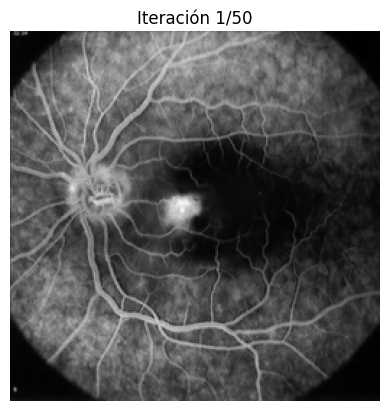

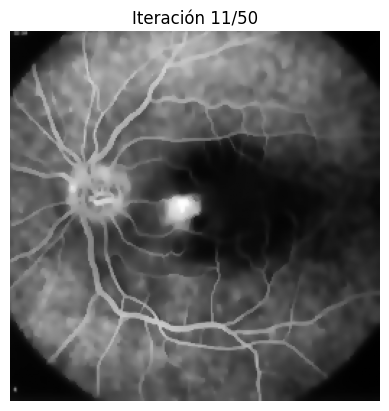

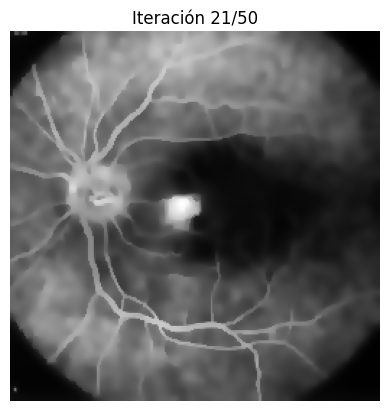

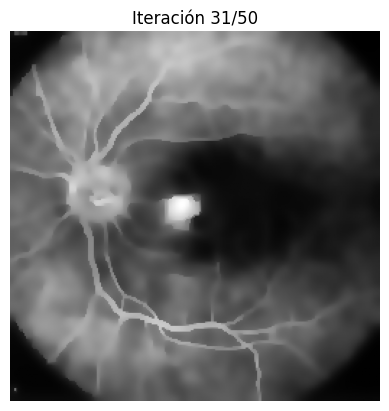

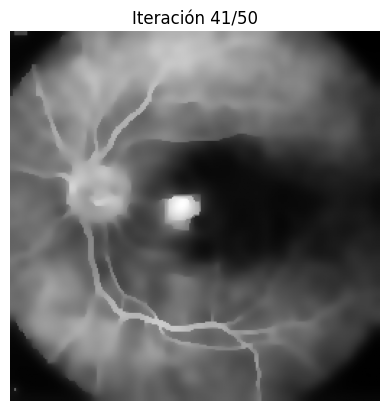

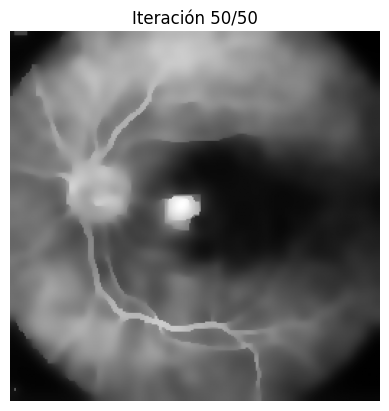

In [33]:

#Ruta base de las imágenes y generar la ruta completa
ruta_imagen = os.path.join(dir_base_imagenes, 'retina.bmp')
imagen_original = plt.imread(ruta_imagen)



#Mostrar la imagen original
plt.imshow(imagen_original, cmap='gray')
plt.title("Imagen Original")
plt.axis('off')
plt.show()

#Parámetros
step_size = 0.25
num_iters = 50
kappa = 10
show_interval = 10

#Aplicar la difusión anisotrópica y mostrar resultados intermedios y final
imagen_final = anisotropic_diffusion(imagen_original, step_size, num_iters, kappa, option='Lorentz', padding='edge', show_interval=show_interval)


### d) Evolución de lineas de nivel

Sobre la imagen oclusion.bmp, aplicar ruido y mejorar la imagen con difusión anisotrópica.
- Ruido gaussiano de ``sigma=20 ``
- ``num_iters=200``, ``step_size=0.2`` y ``kappa=3``
- Quedarse con los resultados cada 25 iteraciones

Mostrar cómo evolucionan de las líneas de nivel cada 25 iteraciones. Para ello elegir 3 o 4 niveles de gris (por ejemplo: 50, 150, 220). Se recomienda utilizar plt.contour


In [34]:
# Aplicar ruido y mejorar imagen con difusión anisotrópica

#----------------------------------------------------------------------
#IMPORTANTE: Se modifica la función para mostrar resultados intermedios
#-----------------------------------------------------------------------
def anisotropic_diffusion(I, step_size, num_iters, kappa, option='Lorentz', padding='edge', show_interval=25):

    I = I.astype(np.float32)

    #Diccionario para almacenar estados intermedios
    resultados = {}

    for iteration in range(num_iters):
        I_pad = np.pad(I, pad_width=1, mode=padding)

        dN = I_pad[0:-2, 1:-1] - I
        dS = I_pad[2:  , 1:-1] - I
        dW = I_pad[1:-1, 0:-2] - I
        dE = I_pad[1:-1, 2:  ] - I

        if option == 'Leclerc':
            cN = np.exp(-(dN**2) / (kappa**2))
            cS = np.exp(-(dS**2) / (kappa**2))
            cW = np.exp(-(dW**2) / (kappa**2))
            cE = np.exp(-(dE**2) / (kappa**2))
        elif option == 'Lorentz':
            cN = 1.0 / (1.0 + (dN**2) / (kappa**2))
            cS = 1.0 / (1.0 + (dS**2) / (kappa**2))
            cW = 1.0 / (1.0 + (dW**2) / (kappa**2))
            cE = 1.0 / (1.0 + (dE**2) / (kappa**2))
        else:
            raise ValueError("La opción debe ser 'Leclerc' o 'Lorentz'.")

        I = I + step_size * (cN * dN + cS * dS + cW * dW + cE * dE)

        #Se almacenan los resultados intermedios cada "show_interval" iteraciones y en la última iteración
        if iteration % show_interval == 0 or iteration == num_iters - 1:
            resultados[iteration] = I.copy()

    return I, resultados

# Cargar imagen original y, de ser necesaria, convertirla a escala de grises
ruta_imagen = os.path.join(dir_base_imagenes, 'oclusion.bmp')
imagen_original = plt.imread(ruta_imagen)


#Si la imagen no tiene un único valor
if imagen_original.shape != 1:
    #Separar los tres canales
    R = imagen_original[:, :, 0]
    G = imagen_original[:, :, 1]
    B = imagen_original[:, :, 2]

    #Para tener un único valor de intensidad de ese pixel hago el promedio de los tres canales
    imagen_original = (R + G + B) / 3.0



#Ruido gaussiano sigma=20
sigma = 20
imagen_ruidosa = add_gaussian_noise(imagen_original, sigma)

#Niveles de gris a mostrar
niveles = [50, 150, 220]

#plt.contour para mostrar las lineas de nivel
plt.figure(figsize=(6,6))
plt.imshow(imagen_ruidosa, cmap='gray')
contornos = plt.contour(imagen_ruidosa, levels=niveles, colors='red')
plt.title("Imagen Ruidosa con Líneas de Nivel")
plt.axis('off')
plt.show()

#Nuevos parametros
num_iters = 200
step_size = 0.2
kappa = 3
show_interval = 25


#Aplico difusion anisotropica y muestro resultados intermedios
imagen_final, resultados_intermedios = anisotropic_diffusion(imagen_ruidosa, step_size, num_iters, kappa, option='Lorentz', padding='edge', show_interval=show_interval)


for iteration, imagen_state in resultados_intermedios.items():
    plt.figure(figsize=(6,6))
    plt.imshow(imagen_state, cmap='gray')
    contornos = plt.contour(imagen_state, levels=niveles, colors='red')
    plt.title(f"Iteración {iteration + 1}")
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

_Responder:_

- ¿Qué pasa con el ruido a lo largo de las iteraciones?

A medida que avanzan las iteraciones, la difusión anisotrópica va atenuando progresivamente el ruido presente en la imagen.
En las primeras iteraciones, se reduce el ruido en aquellas zonas relativamente homogéneas.
En iteraciones posteriores, se sigue suavizando la textura ruidosa, a la vez que se preservan los bordes de las figuras principales gracias a que el coeficiente de difusión es menor cuando el gradiente es más grande, detectando de de forma progresiva el borde.

Finalmente, el ruido tiende a desapareceer, pero manteniendo las estructuras principales se mantienen definidas.

- ¿A qué "_convergen_" las lineas de nivel?

Cómo las lineas de nivel son curvas que conectan puntos con la misma intensidad de gris, por lo que al reducirse el ruido interior de la regiones homogeneas, las lineas de nivel marcan las fronteras entre objetos dentro de una imagen. tienden a marcar fronteras. O sea superficies homogeneas en el interior y contornos conservados.

- ¿Esto se cumpliría usando difusión isotrópica? ¿Por qué?

La difusión isotrópica (por ejemplo, el filtrado Gaussiano iterativo o la ecuación del calor clásica) aplica el mismo nivel de suavizado en todas las direcciones, sin distinguir bordes:

No preserva los bordes de la misma manera que la anisotrópica. Con difusión isotrópica, las líneas de nivel terminarían por “desdibujarse” y los contornos de los objetos se difuminarían progresivamente.

A medida que se itera la difusión isotrópica, la imagen tiende hacia una intensidad promedio global, perdiendo detalles y bordes, porque no existe un mecanismo que atenúe el suavizado cerca de los gradientes altos.

Por tanto, no se cumpliría el mismo comportamiento de convergencia a contornos bien definidos ni la preservación de las estructuras principales que vemos con difusión anisotrópica. La razón es que, en la difusión anisotrópica, la “conductividad” o “coeficiente de difusión” depende del gradiente local (o de la magnitud del borde), limitando la difusión cerca de contornos marcados y permitiendo un mayor suavizado en zonas homogéneas.
...

### e) Cuantificar la reducción de ruido

En esta parte se contaminan imágenes con distintos ruidos, se procesan con diversos métodos y se calculan métricas para cuantificar la reducción de ruido.

* Imágenes: Las dos imágenes elegidas, una artificial y una natural  
* Ruidos:
    * Gaussiano de sigma = 10, 20 y 40
    * Sal y pimienta con  p = 0.3, 0.5 y 0.8
* Métodos:
    * Filtro de media con filter_size = 3 y 5
    * Filtro de mediana con filter_size = 3 y 5
    * Difusión anisotrópica. Variar agun valor de  Kappa
    * NLM de skimage
    * (opcional) Otros métodos
* Métricas:
    * RMSE (no normalizado)
    * PSNR
    * SSIM

Como la cantidad de combinaciones es importante, les sugerimos usar una planilla como la provista en el directorio **datos** la cual se deberá adaptar. Un ejemplo de uso se puede ver en la celda siguiente


Las métricas a usar pueden encontrarse en [skimage.metrics ](https://scikit-image.org/docs/stable/api/skimage.metrics.html)




In [41]:
import pandas as pd

# EJEMPLO DE TABLA DE DENOSING - Adaptar el archivo csv a su experimento -------------

dir_base_datos = '/content/drive/MyDrive/timag/entregable_1/datos'
ruta_tb_denoising = os.path.join(dir_base_datos,'denoising_table.csv')

df = pd.read_csv(ruta_tb_denoising)
df


IMAGE        NOISE_FUNCTION   NOISE_PARAMS     DENOISING_FUNCTION  \
0   oclusion.bmp    add_gaussian_noise   {'sigma': 5}                    NaN   
1   oclusion.bmp    add_gaussian_noise   {'sigma': 5}            mean_filter   
2   oclusion.bmp    add_gaussian_noise   {'sigma': 5}            mean_filter   
3   oclusion.bmp    add_gaussian_noise   {'sigma': 5}          median_filter   
4   oclusion.bmp    add_gaussian_noise   {'sigma': 5}          median_filter   
5   oclusion.bmp    add_gaussian_noise   {'sigma': 5}  anisotropic_diffusion   
6   oclusion.bmp    add_gaussian_noise   {'sigma': 5}  anisotropic_diffusion   
7   oclusion.bmp    add_gaussian_noise  {'sigma': 20}                    NaN   
8   oclusion.bmp    add_gaussian_noise  {'sigma': 20}            mean_filter   
9   oclusion.bmp    add_gaussian_noise  {'sigma': 20}            mean_filter   
10  oclusion.bmp    add_gaussian_noise  {'sigma': 20}          median_filter   
11  oclusion.bmp    add_gaussian_noise  {'sigma': 20}          median_filter   
12  oclusion.bmp    add_gaussian_noise  {'sigma': 20}  anisotropic_diffusion   
13  oclusion.bmp    add_gaussian_noise  {'sigma': 20}  anisotropic_diffusion   
14   peppers.png    add_gaussian_noise  {'sigma': 20}                    NaN   
15   peppers.png    add_gaussian_noise  {'sigma': 20}            mean_filter   
16   peppers.png    add_gaussian_noise  {'sigma': 20}            mean_filter   
17   peppers.png    add_gaussian_noise  {'sigma': 20}          median_filter   
18   peppers.png    add_gaussian_noise  {'sigma': 20}          median_filter   
19   peppers.png    add_gaussian_noise  {'sigma': 20}  anisotropic_diffusion   
20   peppers.png    add_gaussian_noise  {'sigma': 20}  anisotropic_diffusion   
21  oclusion.bmp  add_saltpepper_noise    {'p': 0.05}                    NaN   
22  oclusion.bmp  add_saltpepper_noise    {'p': 0.05}            mean_filter   
23  oclusion.bmp  add_saltpepper_noise    {'p': 0.05}            mean_filter   
24  oclusion.bmp  add_saltpepper_noise    {'p': 0.05}          median_filter   
25  oclusion.bmp  add_saltpepper_noise    {'p': 0.05}          median_filter   
26  oclusion.bmp  add_saltpepper_noise    {'p': 0.05}  anisotropic_diffusion   
27  oclusion.bmp  add_saltpepper_noise    {'p': 0.05}  anisotropic_diffusion   
28  oclusion.bmp  add_saltpepper_noise     {'p': 0.3}                    NaN   
29  oclusion.bmp  add_saltpepper_noise     {'p': 0.3}            mean_filter   
30  oclusion.bmp  add_saltpepper_noise     {'p': 0.3}            mean_filter   
31  oclusion.bmp  add_saltpepper_noise     {'p': 0.3}          median_filter   
32  oclusion.bmp  add_saltpepper_noise     {'p': 0.3}          median_filter   
33  oclusion.bmp  add_saltpepper_noise     {'p': 0.3}  anisotropic_diffusion   
34  oclusion.bmp  add_saltpepper_noise     {'p': 0.3}  anisotropic_diffusion   
35   peppers.png  add_saltpepper_noise     {'p': 0.3}                    NaN   
36   peppers.png  add_saltpepper_noise     {'p': 0.3}            mean_filter   
37   peppers.png  add_saltpepper_noise     {'p': 0.3}            mean_filter   
38   peppers.png  add_saltpepper_noise     {'p': 0.3}          median_filter   
39   peppers.png  add_saltpepper_noise     {'p': 0.3}          median_filter   
40   peppers.png  add_saltpepper_noise     {'p': 0.3}  anisotropic_diffusion   
41   peppers.png  add_saltpepper_noise     {'p': 0.3}  anisotropic_diffusion   

                                     DENOISING_PARAMS  RMSE  PSNR  SSIM  Obs  
0                                                 NaN   NaN   NaN   NaN  NaN  
1                                   {'filter_size':3}   NaN   NaN   NaN  NaN  
2                                   {'filter_size':5}   NaN   NaN   NaN  NaN  
3                                   {'filter_size':3}   NaN   NaN   NaN  NaN  
4                                   {'filter_size':5}   NaN   NaN   NaN  NaN  
5   {'step_size':0.1, 'num_iters':20, 'kappa':1, '...   NaN   NaN   NaN  NaN  
6   {'step_size':

In [ ]:
# EJEMPLO DE EJECUCION CON LA TABLA DE DENOISING --------------------------

show_images = False
for index, row in df.iterrows():  # recorrer todas las filas de la tabla

    image_name = row.IMAGE
    # a) Cargar la imagen
    # COMPLETAR
    I = ...

    # b) Convertir a gris en caso de ser necesario
    # COMPLETAR

    # c) Aplicar el ruido
    np.random.seed(42) # fijar la semilla si se desea reproducibilidad
    noise_function = eval(row.NOISE_FUNCTION)
    noise_params = eval(row.NOISE_PARAMS)
    I_noisy = noise_function(I, **noise_params)


    # d) Restaurar
    if pd.isna(row['DENOISING_FUNCTION']):
        # si no se restaura, para medir el ruido original antes de la restauración
        I_restored = I_noisy
    else:
        denoising_function = eval(row.DENOISING_FUNCTION)
        denoising_params = eval(row.DENOISING_PARAMS)
        I_restored = denoising_function(I_noisy, **denoising_params)

    # e) Calcular metricas
    # COMPLETAR
    rmse = ...
    psnr = ...
    ssim = ...

    # f) Actualizar las metricas en el dataframe
    # COMPLETAR

    # g) Mostrar las imagenes (original, ruidosa y restaurada)
    if show_images:
        # COMPLETAR
        pass

# Guardar la tabla con las metricas
# COMPLETAR

AttributeError: 'ellipsis' object has no attribute 'astype'

In [42]:
from skimage import io, color
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity


show_images = False

#Para no reescribir la variable
base_image_dir = dir_base_imagenes

for index, row in df.iterrows():
    # a) Cargar la imagen
    image_name = row.IMAGE  # Ejemplo: "imagen_artificial.png" o "imagen_natural.jpg"
    image_path = os.path.join(base_image_dir, image_name)
    I = imread(image_path)

    # b) Convertir a gris en caso de ser necesario.
    # Si la imagen tiene 3 o más dimensiones (color), se pasa a escala de grises.
    if I.ndim == 3:
        I = color.rgb2gray(I)  # Esto retorna una imagen en float [0,1]
        # Convertir a rango [0,255] y tipo uint8
        I = (I * 255).astype(np.uint8)

    # c) Aplicar el ruido
    np.random.seed(42)  # Para reproducibilidad
    noise_function = eval(row.NOISE_FUNCTION)
    noise_params = eval(row.NOISE_PARAMS)
    I_noisy = noise_function(I, **noise_params)

    # d) Restaurar
    if pd.isna(row['DENOISING_FUNCTION']):
        #Si no se especifica función de restauración, se mide el ruido original
        I_restored = I_noisy
    else:
        denoising_function = eval(row.DENOISING_FUNCTION)
        denoising_params = eval(row.DENOISING_PARAMS)
        I_restored = denoising_function(I_noisy, **denoising_params)

    # e) Calcular metricas
    mse = mean_squared_error(I, I_restored)
    rmse = np.sqrt(mse)
    psnr = peak_signal_noise_ratio(I, I_restored, data_range=255)
    ssim = structural_similarity(I, I_restored, data_range=255)

    # f) Actualizar las metricas en el dataframe
    df.loc[index, "RMSE"] = rmse
    df.loc[index, "PSNR"] = psnr
    df.loc[index, "SSIM"] = ssim

    # g) Mostrar las imágenes (original, ruidosa y restaurada)
    if show_images:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(I, cmap='gray')
        axs[0].set_title("Imagen Original")
        axs[0].axis('off')
        axs[1].imshow(I_noisy, cmap='gray')
        axs[1].set_title("Imagen Ruidosa")
        axs[1].axis('off')
        axs[2].imshow(I_restored, cmap='gray')
        axs[2].set_title("Imagen Restaurada")
        axs[2].axis('off')
        plt.tight_layout()
        plt.show()

# Guardar la tabla con las metricas
#Ruta completa para el archivo CSV
ruta_destino = os.path.join(dir_base_datos, 'resultados_denoising.csv')
df.to_csv(ruta_destino, index=False)


#### Métrica SSIM
* Explicar qué aspectos se tienen en cuenta en la métrica.   
* Explicar brevemente cómo se calcula y de qué forma se contempla lo anterior.
* Qué ventajas presenta respecto de RMSE y PSNR ?



Respuesta:
Structural Similarity Index Measure(SSIM) compara estructuras locales en la imagen y no diferencias "puntuales" en intensidad. La comparación siempre es entre la imagen original(x) y la imagen restaurada(filtrada) luego de aplicar ruido(y).
Definida en el código como ssim = structural_similarity(I, I_restored, data_range=255)

Se cácula por ventanas o bloques locales que proporcionan un valor de SSIM que refleja qué tan similar es la porción de la imagen procesada, a la porción correspondiente de la imagen original. Después se promedian estos valores, para obtener un único valor de SSIM que representa la similitud estructural de la imagen restaurada en relación a la original.

Para los calculos se considera tres factores:

Luminancia: Compara el nivel medio de intensidad de las ventanas locales en la imagen original(μx) y la restaurada (μy).

Contraste: Medido a través de la desviación estándar (σx y σy), ya que la dispersión de los valores de intensidad alrededor de una media en una ventana, nos habala del contraste. Una ventana con baja variabilidad tiene poco contraste, mientras que una con alta variabilidad tiene mayor contraste.

Estructura: Se usa covarianza(σxy), cómo varían dos variables de forma conjunta,n el caso de SSIM, se utiliza para comparar la estructura o la correlación local entre las intensidades de la imagen original y la imagen restaurada (en la misma ventana). Si las variaciones de intensidad, como bordes y patrones de ambas ventanas son similares, la covarianza tendrá un valor alto, lo que indica una buena preservación de la estructura.


#### Analizar los resultados de la ejecución de los distintos métodos

* Resumir los resultados numéricos para poder extraer conclusiones
* Comentar los resultados para los distintos métodos
* Comentar el efecto que tienen los parámetros
* Ver cuáles métodos son más apropiados para cada ruido. Relacionar con las características del ruido y las hipótesis de las que parte cada método.
* Agregar otros comentarios que entienda pertinente

Respuesta:

In [44]:

ruta_tb_resultados = os.path.join(dir_base_datos,'resultados_denoising.csv')

df = pd.read_csv(ruta_tb_resultados)
df


# Configurar el agrupamiento
group_cols = ['IMAGE', 'NOISE_FUNCTION', 'NOISE_PARAMS']

# Función para extraer la fila con máximo SSIM en un grupo
def get_max_ssim(group):
    return group.loc[group['SSIM'].idxmax()]

# Función para extraer la fila con mínimo SSIM, filtrando solo filas donde DENOISING_FUNCTION no es NaN.
def get_min_ssim_filtered(group):
    filtered = group[group['DENOISING_FUNCTION'].notna()]
    if not filtered.empty:
        return filtered.loc[filtered['SSIM'].idxmin()]
    else:
        # Si en el grupo no hay ninguna restauración, se devuelve None (podrías optar por descartar estos grupos)
        return None

# Recorrer cada grupo y extraer los casos representativos.
max_ssim_list = []
min_ssim_list = []

for name, group in df.groupby(group_cols):
    max_row = get_max_ssim(group)
    min_row = get_min_ssim_filtered(group)
    max_ssim_list.append(max_row)
    if min_row is not None:
        min_ssim_list.append(min_row)

# Convertir las listas a DataFrames
max_ssim_df = pd.DataFrame(max_ssim_list)
min_ssim_df = pd.DataFrame(min_ssim_list)

# Combinar ambos subconjuntos
representative_df = pd.concat([max_ssim_df, min_ssim_df], ignore_index=True)
representative_df.sort_values(by=group_cols, inplace=True)
representative_df.reset_index(drop=True, inplace=True)

# Opcional: Configurar pandas para visualizar todas las filas en Colab
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Casos representativos (máximo y mínimo SSIM entre restauración) por grupo:")
print(representative_df.to_string())

# Guardar el DataFrame resultante en la carpeta de datos
ruta_resultados = os.path.join(dir_base_datos, 'resultados_representativos.csv')
representative_df.to_csv(ruta_resultados, index=False)




Casos representativos (máximo y mínimo SSIM entre restauración) por grupo:
           IMAGE        NOISE_FUNCTION   NOISE_PARAMS     DENOISING_FUNCTION                                                   DENOISING_PARAMS       RMSE       PSNR      SSIM  Obs
0   oclusion.bmp    add_gaussian_noise  {'sigma': 20}            mean_filter                                                  {'filter_size':5}   7.144072  31.051887  0.824857  NaN
1   oclusion.bmp    add_gaussian_noise  {'sigma': 20}  anisotropic_diffusion   {'step_size':0.1, 'num_iters':20, 'kappa':1, 'option':'Leclerc'}  20.036698  22.094280  0.180204  NaN
2   oclusion.bmp    add_gaussian_noise   {'sigma': 5}  anisotropic_diffusion  {'step_size':0.1, 'num_iters':20, 'kappa':10, 'option':'Leclerc'}   0.803267  50.033601  0.994230  NaN
3   oclusion.bmp    add_gaussian_noise   {'sigma': 5}  anisotropic_diffusion   {'step_size':0.1, 'num_iters':20, 'kappa':1, 'option':'Leclerc'}   4.984567  34.178255  0.724196  NaN
4   oclusion.bmp  ad

####Utilicé la pre-visulización de la tabla con los resultados filtrdos.

Comparación para ruido gaussiano:

###  Ruido Gaussiano

1) Difusión Anisotrópica

Un ejemplo destacado, para oclusion.bmp, on σ=5 y kappa=10, se registró un SSIM muy cercano a 1 (0.994).Eso quiere decir que cuando kappa está bien está bien ajustado, logra muy buenos resultados conservndo la forma y reduciendo de manera notable el ruido gaussiano.

Varios resultados muestran que si kappa es muy bajo y el ruido gussino alto (σ=20), la difusión no cumple su trabajo. Por ello la importancia de calibrar k y el numero de iteraciones, en función de la magnitud del ruido.

2) Filtrado de media

Ofrece una reducción del ruido mmenor, pero tiende a suavizar detlles valiosos.


### Ruido Sal y Pimienta

1) Mediana

Tanto para oclusion como para peppers, el filtro de mediana demuestra ser la opción más sólida al enfrentar ruido impulsivo. Los resultados exhiben SSIM muy altos, varios por encima de 0.9, incluso con niveles de ruido relativamente elevados (p=0.3). Esto comprueba lo bueno que es dicho filtro frente valores atipicos.

2) Difusión Anisotrópica

Las configuraciones de difusión anisotrópica probadas no mostraron buen desempeño al enfrentar niveles altos de ruido sal y pimienta. Se presentaron SSIM muy bajos, menores a 0.1, en algunos casos.

### Comparativa: Imágenes Artificiales vs. Naturales

1) Imágenes artificial (oclusion)

Presentan bordes nítidos, regiones planas y formas geométricas simples. Esto hace que los métodos de filtrado que preservan bordes (como la difusión anisotrópica) resulten muy eficaces.

Para ruido sal y pimienta, la mediana ofrece resultados muy buenos, ya que puede eliminar los valores atipicos.

En resumen las imagenes artificiles nos permiten distinguir con claridad los errores y aciertos de cada método, debido a las zonas homogéneas y bordes, claramente definidos

2) Imagenes Naturales (peppers)

Tienen texturas complejas, lo que demanda un ajuste de parámetros aún más cuidadoso para no perder detalles finos ni dejar remanentes de ruido.

Los métodos se deben afinar más, ya que el ruido es mas dificil eliminrlo por las texturas. También puede dañar detalles si no se lo maneja bien.





